In [1]:
from pprint import pprint
from torch_geometric.data import Data, DataListLoader, Dataset, InMemoryDataset, Batch
from torch_geometric.loader import DataListLoader, DataLoader
from torch_geometric.nn import *
from torch_geometric.utils import to_dense_adj, to_dense_batch, add_self_loops, remove_self_loops
from torch_geometric.nn.conv import MessagePassing
import torch
from torch import nn
import rdkit
from tqdm.auto import tqdm
import itertools
from rdkit import Chem
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
from rdkit import RDLogger

from copy import deepcopy
#from torch.utils.data import Dataset, DataLoader
from typing import Tuple, List, Dict, Union
from torch import Tensor
from torch_geometric.nn import MessagePassing, radius_graph
from torch_geometric.utils import add_self_loops, degree
from torch_scatter import scatter
from torch_geometric.typing import (
    Adj,
    OptTensor,
    SparseTensor,
    pyg_lib,
    torch_sparse,
)
from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
    extract_zip,
)
from rdkit import Chem
import os
# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')
cuda=torch.device('cuda') if torch.cuda.is_available() else 'cpu'
import sascorer
#torch.set_default_dtype(torch.float64)
from models import *
from rdkit.Chem.Crippen import MolLogP
from typing import List
from prolog import *
import torchlens as tl

In [2]:
sup=Chem.SDMolSupplier("datasets/qm9/raw/gdb9.sdf")

In [3]:
qm9=QM9("datasets/qm9")

In [4]:
TEST_SIZE=1024
train_dataset, test_dataset = torch.utils.data.random_split(qm9, [len(qm9)-1024, 1024])

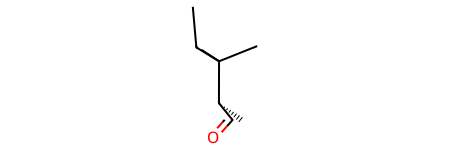

In [5]:
sample_idx=100_000
sample=qm9[sample_idx]
sup[sample_idx]

In [6]:
bl=DataLoader(train_dataset, batch_size=64, )

In [7]:
# example
show(sup[sample_idx])  # or 'P'

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

count         mean          std          min          25%  \
A          133885.0     9.814382  1809.465666     0.000000     2.554430   
B          133885.0     1.406097     1.583795     0.337120     1.091630   
C          133885.0     1.124921     1.095618     0.331180     0.910480   
mu         133885.0     2.706037     1.530394     0.000000     1.588700   
alpha      133885.0    75.191296     8.187793     6.310000    70.380000   
homo       133885.0    -0.239977     0.022131    -0.428600    -0.252500   
lumo       133885.0     0.011124     0.046936    -0.175000    -0.023800   
gap        133885.0     0.251100     0.047519     0.024600     0.216300   
r2         133885.0  1189.527450   279.757172    19.000200  1018.322600   
zpve       133885.0     0.148524     0.033274     0.015951     0.125289   
u0         133885.0  -411.543985    40.060230  -714.568061  -437.913936   
u298       133885.0  -411.535513    40.060012  -714.560153  -437.905942   
h298       133885.0  -411.534569    40.060012  -714.559209  -437.904997   
g298       133885.0  -411.577397    40.060741  -714.602138  -437.947682   
cv         133885.0    31.600676     4.062471     6.002000    28.942000   
u0_atom    133885.0 -1750.812997   239.313373 -2608.448864 -1904.772194   
u298_atom  133885.0 -1761.480647   241.436103 -2626.408172 -1916.981009   
h298_atom  133885.0 -1771.546928   243.151065 -2643.007040 -1928.181417   
g298_atom  133885.0 -1629.388196   220.207088 -2417.121997 -1771.350603   

                   50%          75%            max  
A             3.090360     3.835820  619867.683140  
B             1.369940     1.653980     437.903860  
C             1.078560     1.279540     282.945450  
mu            2.500000     3.636100      29.556400  
alpha        75.500000    80.520000     196.620000  
homo         -0.241000    -0.228700      -0.101700  
lumo          0.012000     0.049200       0.193500  
gap           0.249400     0.288200       0.622100  
r2         1147.585800  1308.816600    3374.753200  
zpve          0.148329     0.171150       0.273944  
u0         -417.864758  -387.049166     -40.478930  
u298       -417.857351  -387.039746     -40.476062  
h298       -417.856407  -387.038802     -40.475117  
g298       -417.895731  -387.083279     -40.498597  
cv           31.555000    34.276000      46.969000  
u0_atom   -1753.464714 -1596.871098    -213.087624  
u298_atom -1764.090324 -1606.108658    -213.974294  
h298_atom -1774.151176 -1615.066349    -215.159658  
g298_atom -1632.224955 -1488.291333    -201.407171

(-380.1364430652005, 226.3763836451994)

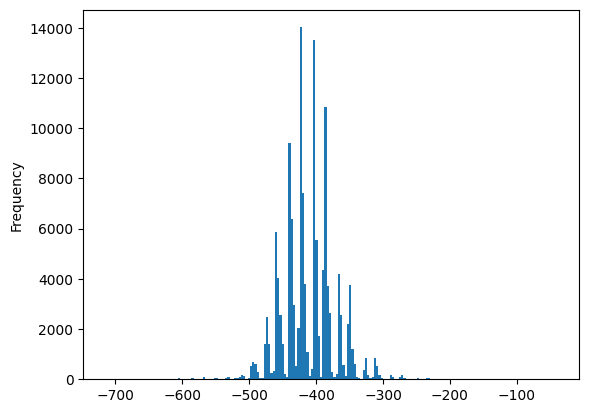

In [8]:
df=pd.read_csv("datasets/qm9/raw/gdb9.sdf.csv")
display(df.describe().T)
YCOL='u0'
#(df[YCOL].quantile([.01,.02,.03,.05,.5,.95,.97,.98,.99]))
__min=df[YCOL].quantile(.0001)
__max=df[YCOL].quantile(.9999)
__mean=df[YCOL].mean()
__std=df[YCOL].std()
df[YCOL].plot.hist(bins=200)
offset=(__min+__max)/2
width=abs(__max-__min)/2
offset,width

In [9]:
class TrainingContext:
    def __init__(self, cls, *args, **kwargs):
        self.inner = cls(*args, **kwargs).to(cuda)
        self.name = cls.__name__
        self.optim = torch.optim.AdamW(self.inner.parameters())
        self.sched = torch.optim.lr_scheduler.ExponentialLR(self.optim, gamma=0.9)
                     #torch.optim.lr_scheduler.ReduceLROnPlateau(self.optim,
                     #                            mode='min',
                     #                            factor=0.5,
                     #                            patience=3)
        self.num_parameters = sum(map(torch.numel,self.inner.parameters()))
        self.train_loss_record = dict()
        self.test_loss_record = dict()
        self.results = list()
        self.total_iters = 0
        self.running_loss = 0
        self.best_eval_loss = 999
        self.stopped = False
        self.batch_size=64
        self.train_loss_metric='MSE'
        self.eval_loss_metric='MAE'
        self.last_target_name='normalized_u0'
        self.last_dataset_name='QM9'
        self.training=True
    def save(self, prefix='saves'):
        save_model(
            self.name,
            self.inner,
            optimizer=self.optim,
            scheduler=self.sched,
            loss_record={
                'train':self.train_loss_record,
                'test':self.test_loss_record,
            },
            total_training_iters=self.total_iters,
            last_batch_size=self.batch_size,
            loss_metric={
                'train':'MSE',
                'test':'MAE',
            },
            last_target_name=self.last_target_name,
            last_dataset_name=self.last_dataset_name
        )
    @classmethod
    def load(cls, name, class_, prefix='saves', training=False, override=None):
        if override is None:
            override=dict()
        checkpoint=torch.load(os.path.join(prefix,name,'checkpoint.pth'))
        self=cls(class_,**dict(**checkpoint['config'],**override))
        self.inner.load_state_dict(checkpoint['model_state_dict'])
        self.optim.load_state_dict(checkpoint['optimizer_state_dict'])
        self.sched.load_state_dict(checkpoint['scheduler_state_dict'])
        self.total_iters=checkpoint['total_training_iters']
        self.batch_size=checkpoint['last_batch_size']
        self.train_loss_record=checkpoint['loss_record']['train']
        self.test_loss_record=checkpoint['loss_record']['test']
        self.best_eval_loss=min(self.test_loss_record.values())
        self.training=training
        return self
    

In [10]:
def find_first_eval_loss_record(cls, hparams=None, override=None, tqdm_handle=None):
    print("find_first_eval_loss_record", cls.__name__)
    import os
    from pathlib import Path
    import pandas as pd
    # Set the directory path
    library_path = Path("./saves/")  # Change to your actual directory
    
    # Get all files (non-recursive) and sort by modification time
    files = sorted(
        [f for f in library_path.iterdir() if not f.is_file() and f.name.startswith(cls.__name__)], 
        key=lambda f: f.stat().st_mtime,  # Sort by modification time
        reverse=True  # Most recently modified first
    )
    
    if hparams is None:
        hparams=dict()
    if override is None:
        override=dict()
    if tqdm_handle is not None:
    # Print results
        tqdm_handle.refresh()
        tqdm_handle.reset(len(files))
    for file in (files):
        if tqdm_handle is not None:
            tqdm_handle.update(1)
        try:
            loaded = TrainingContext.load(file.name, cls, override=override)
        except:
            continue
        cfg = loaded.inner.get_config()
        match_config=True
        for k,v in hparams.items():
            if cfg.get(k)!=v:
                match_config=False
                break
        if not match_config: continue
        return pd.Series(loaded.test_loss_record)



In [11]:
from models.schnet import SchNet
from models.m220 import M220
from models.m305a import M305A
from models.m305b import M305B
from models.m304a import M304A
from models.m304b import M304B
from models.mogin14 import MoGIN14
from models.schnet_minim import SchNetMinim
from models.schnet_generalized import SchNetGeneralized
d={
    'SchNet':(SchNet,{},{}),
    'M220':(M220,{},{}),
    'M305A':(M305A,{},{}),
    'M305B':(M305B,{},{}),
    'M304A':(M304A,{},{}),
    'M304B':(M304B,{},{}),
    'MoGIN14':(MoGIN14,{},{}),
    'SchNetMinim':(SchNetMinim,{},{}),
    'SchNetGeneralized-old-ver':(SchNetGeneralized, {}, {'train_distance_expansion':False}),
    #'SchNetGeneralized':(SchNetGeneralized,{'train_distance_expansion':False}, {'train_distance_expansion':False}),
    #'SchNetGeneralized-pretrained':(SchNetGeneralized,{'train_distance_expansion':True}, {'train_distance_expansion':False}),
}
handle=tqdm()
out={
    name:find_first_eval_loss_record(cls,hparams=cfg,override=ovr,tqdm_handle=handle) for name,(cls,cfg,ovr) in d.items()
}

0it [00:00, ?it/s]

find_first_eval_loss_record SchNet
find_first_eval_loss_record M220
find_first_eval_loss_record M305A
find_first_eval_loss_record M305B
find_first_eval_loss_record M304A
find_first_eval_loss_record M304B
find_first_eval_loss_record MoGIN14
find_first_eval_loss_record SchNetMinim
find_first_eval_loss_record SchNetGeneralized


In [8]:
{
    k:type(v) for k,v in out.items()
}

{'SchNet': pandas.core.series.Series,
 'M220': pandas.core.series.Series,
 'M305A': pandas.core.series.Series,
 'M305B': pandas.core.series.Series,
 'M304A': pandas.core.series.Series,
 'M304B': pandas.core.series.Series,
 'MoGIN14': pandas.core.series.Series,
 'SchNetMinim': pandas.core.series.Series,
 'SchNetGeneralized-old-ver': pandas.core.series.Series,
 'SchNetGeneralized': NoneType,
 'SchNetGeneralized-pretrained': NoneType}

In [9]:
styles={
    'SchNet': {'c':'r','style':'-'},
    'M220': {'c':'g','style':'-'},
    'M305A': {'c':'b','style':'-'},
    'M305B': {'c':'b','style':'--'},
    'M304A': {'c':'y','style':'-'},
    'M304B': {'c':'y','style':'--'},
    'MoGIN14': {'c':'k','style':'-'},
    'SchNetMinim': {'c':'m','style':'-'},
    'SchNetGeneralized-old-ver': {'c':'m','style':'--'},
    'SchNetGeneralized': {},
    'SchNetGeneralized-pretrained': {},
}

In [17]:
for (name,stats) in out.items():
    if stats is None: continue
    print(name,int(10000*stats.min())/10000)

SchNet 0.0009
M220 0.0013
M305A 0.0051
M305B 0.005
M304A 0.0036
M304B 0.0023
MoGIN14 0.0015
SchNetMinim 0.0015
SchNetGeneralized-old-ver 0.0011


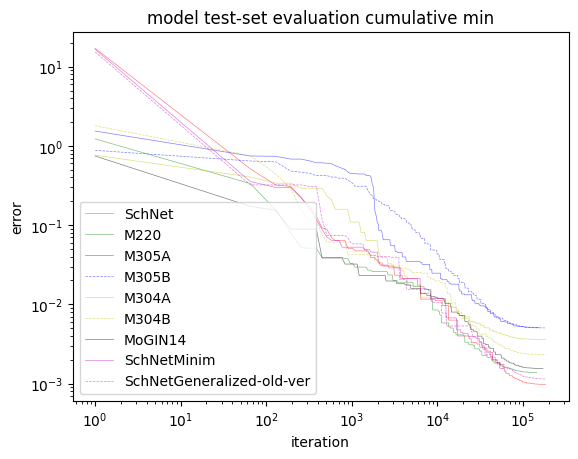

In [14]:
for (name,stats) in out.items():
    if stats is None: continue
    stats.cummin().plot(label=name,alpha=0.5,lw=0.5,**styles[name])
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title("model test-set evaluation cumulative min")
plt.ylabel('error')
plt.xlabel('iteration')
plt.gcf().savefig("combined_diagram.svg")

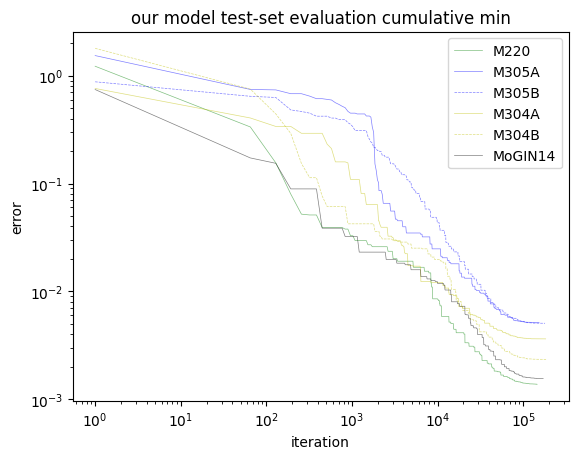

In [15]:
for (name,stats) in out.items():
    if name.startswith("SchNet"): continue
    if stats is None: continue
    stats.cummin().plot(label=name,alpha=0.5,lw=0.5,**styles[name])
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title("our model test-set evaluation cumulative min")
plt.ylabel('error')
plt.xlabel('iteration')
plt.gcf().savefig("our_model_combined_diagram.svg")

In [10]:
class ShiftedSoftplus(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.shift = torch.log(torch.tensor(2.0)).item()

    def forward(self, x: Tensor) -> Tensor:
        return nn.functional.softplus(x) - self.shift

In [11]:
from models.mogin13 import load_balancing_loss

In [11]:
import gc
models=[]
gc.collect()
torch.cuda.empty_cache()

In [12]:
from models.schnet import SchNet

models.append(TrainingContext(SchNet))
models[-1].num_parameters

455809

In [14]:
from models.schnet_generalized import SchNetGeneralized

models.append(TrainingContext(
    SchNetGeneralized,
    train_distance_expansion=True,
))
models[-1].num_parameters

before: 0.25790536403656006


  0%|          | 0/10000 [00:00<?, ?it/s]

after: 0.000633716641459614


469683

In [15]:
from models.schnet_generalized import SchNetGeneralized

models.append(TrainingContext(
    SchNetGeneralized,
    train_distance_expansion=False,
))
models[-1].num_parameters

before: 0.2385888546705246


  0%|          | 0/10000 [00:00<?, ?it/s]

after: 0.0005813019815832376


469683

In [16]:
cutoff=10
x=torch.linspace(0,cutoff,10_000).to(cuda)
z=(x*2-cutoff).view(-1,1)/cutoff
y=models[-1].inner.gaussian_smear(x)
p=models[-1].inner.distance_expansion(z)

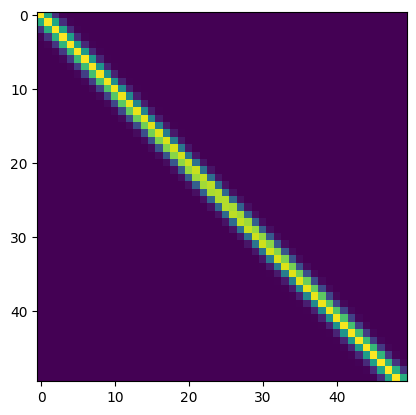

In [17]:
imshow(y[::200])

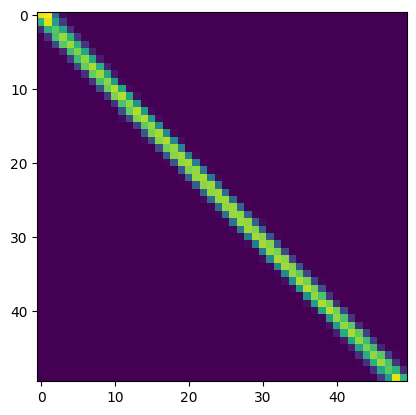

In [18]:
imshow(p[::200])

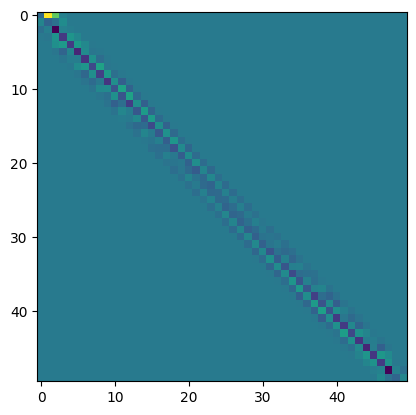

In [19]:
imshow(p[::200]-y[::200])

In [20]:
(p[::500]-y[::500]).std()

tensor(0.0267, device='cuda:0', grad_fn=<StdBackward0>)

In [13]:
from models.m305a import M305A

models.append(TrainingContext(
    M305A,
    node_dimses=[
        [100, 128, 100],#this first element of the first nested list is arbitrary
        [100, 128, 100],
        [100, 128, 100],
        [100, 128, 100],
        [100, 128, 100],
        [100, 128, 1 ],
    ],
    edge_dimses=[
        [1, 256, 64, 64],
        [1, 256, 64, 64],
        [1, 256, 64, 64],
        [1, 256, 64, 64],
        [1, 256, 64, 64],
        [1, 256, 64, 64],
    ],
    activation=nn.SiLU,
    dropout_rate=0,#0.1,#0.01,
))
models[-1].num_parameters

345954

In [14]:
from models.m305b import M305B

models.append(TrainingContext(
    M305B,
    node_dimses=[
        [100, 128, 100],#this first element of the first nested list is arbitrary
        [100, 128, 100],
        [100, 128, 100],
        [100, 128, 100],
        [100, 128, 100],
        [100, 128, 1 ],
    ],
    edge_dimses=[
        [1, 200, 100],
        [1, 200, 100],
        [1, 200, 100],
        [1, 200, 100],
        [1, 200, 100],
        [1, 200, 100],
    ],
    activation=nn.SiLU,
    dropout_rate=0,#0.1,#0.01,
))
models[-1].num_parameters

291642

In [13]:
from models.m307 import M307

models.append(TrainingContext(
    M307,
    node_dimses=[
        [100, 128, 100],#this first element of the first nested list is arbitrary
        [100, 128, 100],
        [100, 128, 100],
        [100, 128, 100],
        [100, 128, 100],
        [100, 128, 1 ],
    ],
    edge_dimses=[
        [1, 200, 100],
        [1, 200, 100],
        [1, 200, 100],
        [1, 200, 100],
        [1, 200, 100],
        [1, 200, 100],
    ],
    activation=nn.SiLU,
    dropout_rate=0,#0.1,#0.01,
    pretrain_edge_mlp=False,
    allow_train_edge_mlp=True,
))
models[-1].num_parameters

292242

In [14]:
from models.m307 import M307

models.append(TrainingContext(
    M307,
    node_dimses=[
        [100, 128, 100],#this first element of the first nested list is arbitrary
        [100, 128, 100],
        [100, 128, 100],
        [100, 128, 100],
        [100, 128, 100],
        [100, 128, 1 ],
    ],
    edge_dimses=[
        [1, 200, 100],
        [1, 200, 100],
        [1, 200, 100],
        [1, 200, 100],
        [1, 200, 100],
        [1, 200, 100],
    ],
    activation=nn.SiLU,
    dropout_rate=0,#0.1,#0.01,
    pretrain_edge_mlp=True,
    allow_train_edge_mlp=False,
))
models[-1].num_parameters

before: 0.2642982602119446


  0%|          | 0/20000 [00:00<?, ?it/s]

after: 0.0015254935715347528


292242

In [13]:
from models.m220 import M220

models.append(TrainingContext(
    M220,
    node_dimses=[
        [100, 128, 100],#this first element of the first nested list is arbitrary
        [100, 128, 100],
        [100, 128, 100],
        [100, 128, 100],
        [100, 128, 100],
        [100, 128, 1 ],
    ],
    edge_dimses=[
        [1, 256, 64, 64],
        [1, 256, 64, 64],
        [1, 256, 64, 64],
        [1, 256, 64, 64],
        [1, 256, 64, 64],
        [1, 256, 64, 64],
    ],
    activation=nn.SiLU,
    dropout_rate=0,#0.1,#0.01,
))
models[-1].num_parameters

445338

In [13]:
from models.m307b import M307B

models.append(TrainingContext(
    M307B,
    node_dimses=[
        [120, 128, 120],#this first element of the first nested list is arbitrary
        [120, 128, 120],
        [120, 128, 120],
        [120, 128, 120],
        [120, 128, 120],
        [120, 128, 1 ],
    ],
    edge_dimses=[
        [50, 200, 120],
        [50, 200, 120],
        [50, 200, 120],
        [50, 200, 120],
        [50, 200, 120],
        [50, 200, 120],
    ],
    activation=nn.SiLU,
    dropout_rate=0,#0.1,#0.01,
))
models[-1].num_parameters

408042

In [14]:
from models.m307c import M307C

models.append(TrainingContext(
    M307C,
    node_dimses=[
        [192, 128, 192],#this first element of the first nested list is arbitrary
        [192, 128, 192],
        [192, 128, 192],
        [192, 128, 192],
        [192, 128, 192],
        [192, 128, 1 ],
    ],
    edge_dimses=[
        [1, 100, 192],
        [1, 100, 192],
        [1, 100, 192],
        [1, 100, 192],
        [1, 100, 192],
        [1, 100, 192],
    ],
    activation=nn.SiLU,
    dropout_rate=0,#0.1,#0.01,
))
models[-1].num_parameters

436842

In [15]:
from models.m307d import M307D

models.append(TrainingContext(
    M307D,
    node_dimses=[
        [192, 128, 192],#this first element of the first nested list is arbitrary
        [192, 128, 192],
        [192, 128, 192],
        [192, 128, 192],
        [192, 128, 192],
        [192, 128, 1 ],
    ],
    edge_dimses=[
        [1, 100, 192],
        [1, 100, 192],
        [1, 100, 192],
        [1, 100, 192],
        [1, 100, 192],
        [1, 100, 192],
    ],
    activation=nn.SiLU,
    dropout_rate=0,#0.1,#0.01,
))
models[-1].num_parameters

435642

In [15]:
cutoff=10
x=torch.linspace(0,cutoff,10_000).to(cuda)
z=torch.linspace(-1,1,10_000).to(cuda).view(-1,1)
y=models[-1].inner.convs[0].gaussian_smear(x)

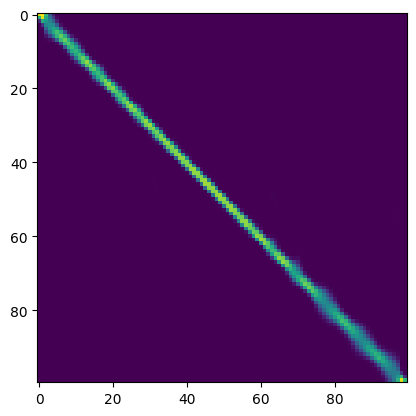

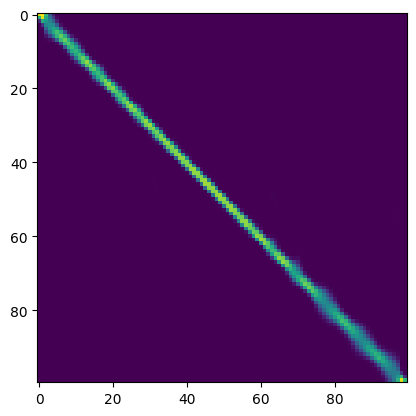

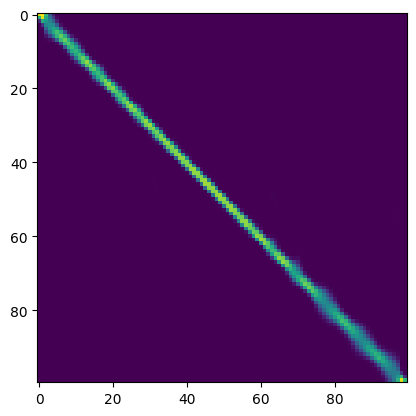

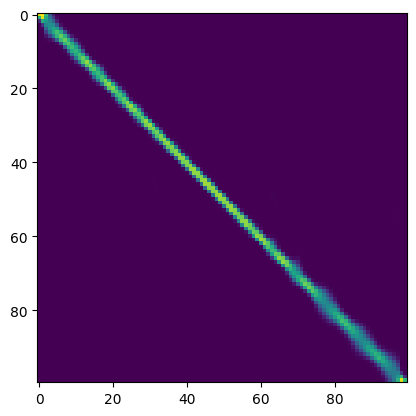

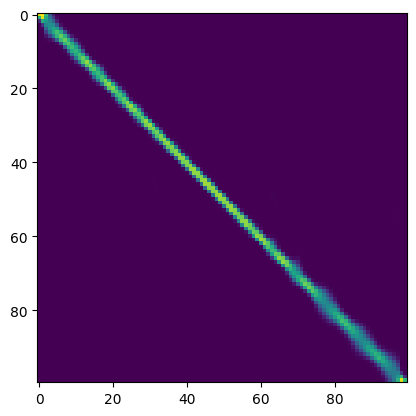

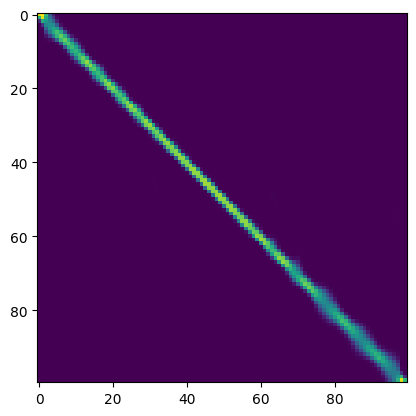

In [16]:
for conv in models[-1].inner.convs:
    p=conv.edge_mlp(z)
    imshow(p[::100])
    plt.show()

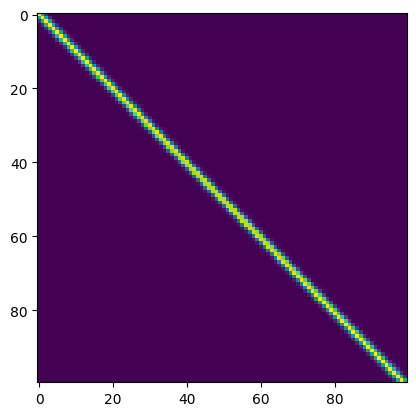

In [17]:
imshow(y[::100])

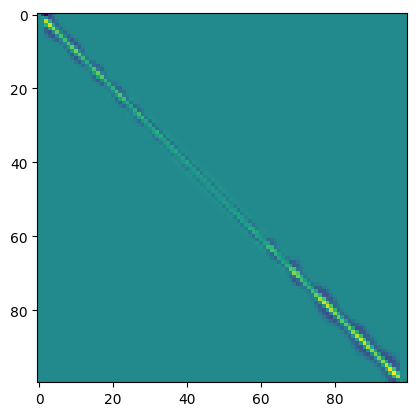

In [18]:
imshow(y[::100]-p[::100])

In [19]:
(y-p).std()

tensor(0.0388, device='cuda:0', grad_fn=<StdBackward0>)

In [15]:
from models.mogin14 import MoGIN14

models.append(TrainingContext(
    MoGIN14,
    node_dimses=[
        [64, 80, 64],#this first element of the first nested list is arbitrary
        [64, 80, 64],
        [64, 80, 64],
        [64, 80, 64],
        [64, 80, 64],
        [64, 80, 1 ],
    ],
    edge_dimses=[
        [1, 64, 32],
        [1, 64, 32],
        [1, 64, 32],
        [1, 64, 32],
        [1, 64, 32],
        [1, 64, 32],
    ],
    router_dimses=[
        [1, 32, 3],
        [1, 32, 3],
        [1, 32, 3],
        [1, 32, 3],
        [1, 32, 3],
        [1, 32, 3],
    ],
    activation=nn.SiLU,
    router_norm=nn.BatchNorm1d,
    edge_norm=nn.BatchNorm1d,
    dropout_rate=0,#0.1,#0.01,
    #node_dropout_rate=0.0,#0.01,
    #edge_dropout_rate=0,#0.1,
    routing_loss_alpha=0,#8.0,
    routing_loss_beta=0,#2.0,
    routing_loss_threshold=0,#0.06,
    with_self_loops=False,
    route_filter=0.0,
))
models[-1].num_parameters

438111

In [16]:
from models.mogin16 import MoGIN16

models.append(TrainingContext(
    MoGIN16,
    node_dimses=[
        [64, 80, 64],#this first element of the first nested list is arbitrary
        [64, 80, 64],
        [64, 80, 64],
        [64, 80, 64],
        [64, 80, 64],
        [64, 80, 1 ],
    ],
    edge_dimses=[
        [1, 64, 32],
        [1, 64, 32],
        [1, 64, 32],
        [1, 64, 32],
        [1, 64, 32],
        [1, 64, 32],
    ],
    router_dimses=[
        [1, 32, 3],
        [1, 32, 3],
        [1, 32, 3],
        [1, 32, 3],
        [1, 32, 3],
        [1, 32, 3],
    ],
    activation=nn.SiLU,
    router_norm=nn.BatchNorm1d,
    edge_norm=nn.BatchNorm1d,
    dropout_rate=0,#0.1,#0.01,
    #node_dropout_rate=0.0,#0.01,
    #edge_dropout_rate=0,#0.1,
    routing_loss_alpha=0,#8.0,
    routing_loss_beta=0,#2.0,
    routing_loss_threshold=0,#0.06,
    with_self_loops=False,
    route_filter=0.0,
))
models[-1].num_parameters

438111

In [16]:
from models.mogin11 import MLP

=== SchNet ===


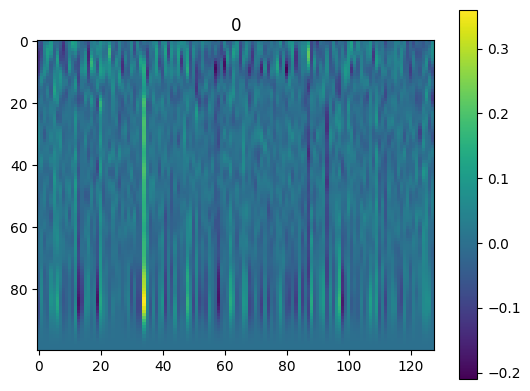

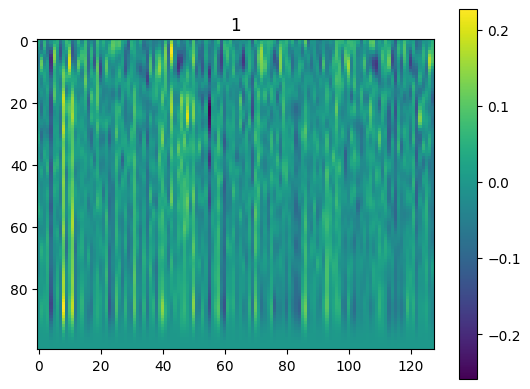

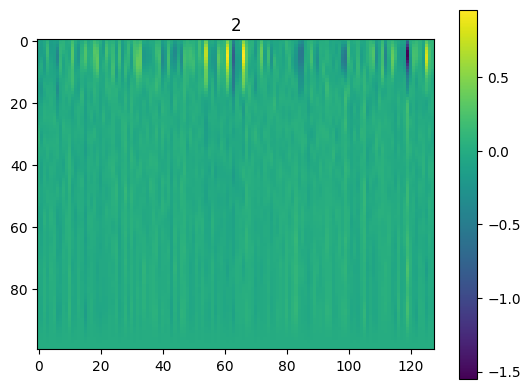

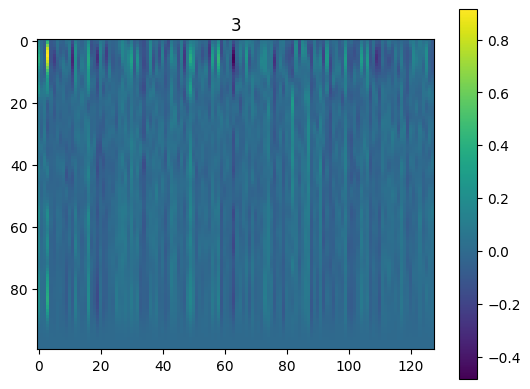

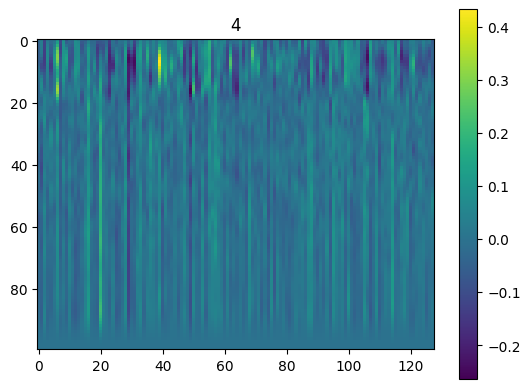

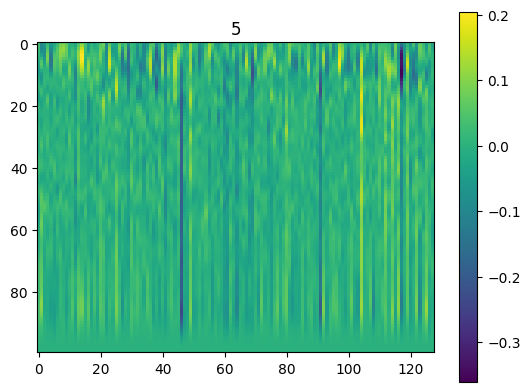

In [18]:
for schnet in models:
    if 'schnet' not in type(schnet.inner).__name__.lower(): continue
    print("===",type(schnet.inner).__name__,"===")
    smear=schnet.inner.distance_expansion(torch.linspace(0,10,100).to(cuda))
    C = 0.5 * (torch.cos(torch.linspace(0,10,100) * torch.pi / 10) + 1.0).to(cuda)
    for i,interaction in enumerate(schnet.inner.interactions):
        tmp=interaction.mlp(smear)*C.view(-1,1)
        #tmp_=conv.edge_mlp(torch.linspace(0,6,100).view(-1,1).to(cuda)).softmax(-1).detach()
        ax=imshow(tmp)
        plt.title(i)
        plt.gcf().colorbar(ax)
        #plt.title(f"{load_balancing_loss(tmp,mogin.inner.routing_loss_alpha,mogin.inner.routing_loss_beta,.003).item():.3f} {(mogin.inner.routing_loss_alpha+mogin.inner.routing_loss_beta)*mogin.inner.routing_loss_threshold}")
        plt.show()

=== M307B ===
Parameter containing:
tensor([0.6867, 0.7059, 0.7173, 0.7210, 0.7273, 0.8228], device='cuda:0',
       requires_grad=True)
--- block ---
Parameter containing:
tensor([0.8289, 0.7131, 0.6784, 0.7061, 0.7239, 0.7154, 0.7089, 0.6409, 0.7217,
        0.7553, 0.6903, 0.6849, 0.7470, 0.7002, 0.6859, 0.7672, 0.7114, 0.7666,
        0.6726, 0.7093, 0.6653, 0.7224, 0.6944, 0.7543, 0.7127, 0.6972, 0.7118,
        0.7390, 0.7809, 0.6711, 0.6406, 0.7216, 0.6991, 0.7134, 0.6880, 0.6950,
        0.7237, 0.6902, 0.7111, 0.6435, 0.7185, 0.7076, 0.7295, 0.7058, 0.6831,
        0.7903, 0.7472, 0.7083, 0.6655, 0.7245, 0.7658, 0.7434, 0.7656, 0.7078,
        0.7560, 0.6314, 0.7300, 0.6974, 0.7447, 0.6952, 0.7202, 0.7182, 0.7385,
        0.6683, 0.7441, 0.7123, 0.7341, 0.7258, 0.7340, 0.7469, 0.6889, 0.7342,
        0.7280, 0.7192, 0.6953, 0.7867, 0.6750, 0.7195, 0.7476, 0.6707, 0.8498,
        0.6945, 0.6923, 0.6710, 0.7559, 0.7868, 0.6882, 0.6979, 0.7166, 0.7118,
        0.7539, 0.6908, 0.7

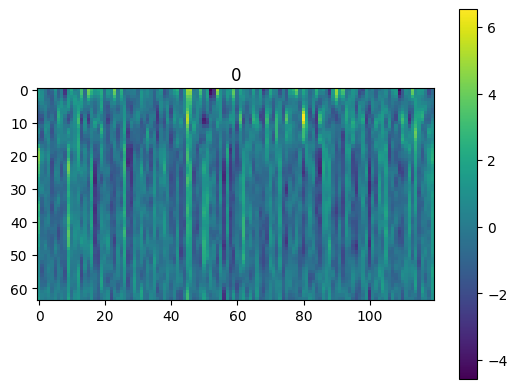

--- block ---
Parameter containing:
tensor([0.7024, 0.7930, 0.7353, 0.6862, 0.7013, 0.7053, 0.6832, 0.6989, 0.7004,
        0.7514, 0.6699, 0.6911, 0.6834, 0.7649, 0.7202, 0.7053, 0.7220, 0.7524,
        0.7216, 0.7016, 0.6917, 0.7077, 0.7542, 0.7524, 0.7537, 0.7278, 0.7741,
        0.8624, 0.7678, 0.8005, 0.7141, 0.7080, 0.7120, 0.7365, 0.7447, 0.6793,
        0.7413, 0.6883, 0.6910, 0.7270, 0.7335, 0.6753, 0.6926, 0.7148, 0.6713,
        0.7364, 0.6397, 0.6780, 0.6727, 0.6466, 0.6737, 0.7299, 0.6928, 0.6665,
        0.6976, 0.6464, 0.6524, 0.6250, 0.7158, 0.7185, 0.6971, 0.6071, 0.7454,
        0.6652, 0.6472, 0.8032, 0.7058, 0.7098, 0.7150, 0.7321, 0.7153, 0.6908,
        0.6952, 0.6774, 0.6991, 0.7720, 0.7491, 0.6736, 0.7193, 0.7023, 0.7614,
        0.7051, 0.7001, 0.7788, 0.7755, 0.7483, 0.7029, 0.8062, 0.7288, 0.7019,
        0.7130, 0.7233, 0.7369, 0.7477, 0.7267, 0.6788, 0.7128, 0.7102, 0.6902,
        0.7231, 0.6927, 0.7243, 0.7290, 0.6840, 0.6999, 0.7659, 0.6590, 0.7284,
    

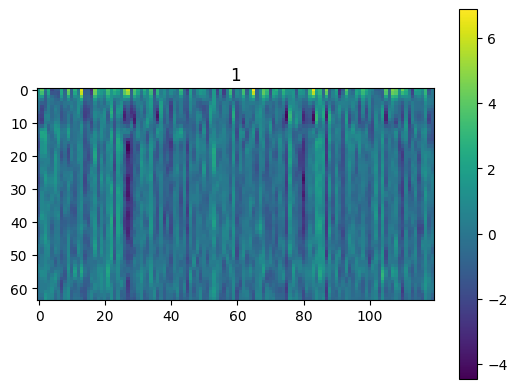

--- block ---
Parameter containing:
tensor([0.7427, 0.6877, 0.6742, 0.6984, 0.7736, 0.7394, 0.6565, 0.6946, 0.6565,
        0.7490, 0.7333, 0.7663, 0.7658, 0.6614, 0.8061, 0.7251, 0.7210, 0.6627,
        0.6854, 0.6874, 0.7394, 0.6626, 0.6470, 0.7699, 0.7901, 0.7109, 0.6830,
        0.7492, 0.7101, 0.7006, 0.6513, 0.7152, 0.7119, 0.7183, 0.7584, 0.6938,
        0.6703, 0.7094, 0.7634, 0.6762, 0.6698, 0.7083, 0.7439, 0.7015, 0.6978,
        0.7093, 0.6751, 0.7231, 0.7475, 0.7040, 0.7518, 0.7548, 0.6900, 0.7716,
        0.6855, 0.6635, 0.6932, 0.7361, 0.7032, 0.7311, 0.7094, 0.6974, 0.7513,
        0.7307, 0.8072, 0.7550, 0.7193, 0.7300, 0.7391, 0.7497, 0.6973, 0.7399,
        0.7874, 0.7286, 0.7261, 0.6981, 0.7212, 0.7084, 0.7211, 0.6874, 0.7132,
        0.7004, 0.7628, 0.6520, 0.6905, 0.7753, 0.7543, 0.8091, 0.6890, 0.7468,
        0.6917, 0.7520, 0.7343, 0.6866, 0.6622, 0.6188, 0.7066, 0.7370, 0.6991,
        0.7111, 0.7288, 0.6947, 0.7334, 0.7323, 0.7481, 0.7278, 0.6904, 0.7550,
    

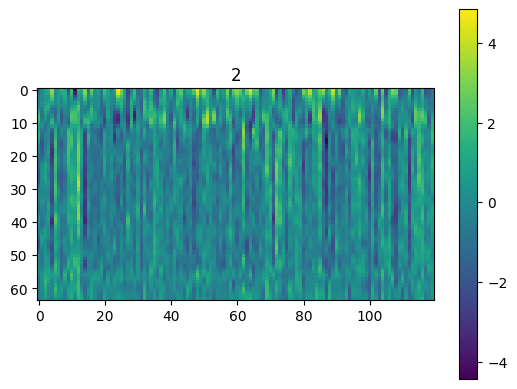

--- block ---
Parameter containing:
tensor([0.7598, 0.6888, 0.6895, 0.7003, 0.6806, 0.7156, 0.7601, 0.6945, 0.7055,
        0.7696, 0.7113, 0.7065, 0.6131, 0.7241, 0.7413, 0.7205, 0.7077, 0.6806,
        0.6845, 0.7227, 0.6888, 0.6491, 0.6924, 0.7410, 0.7083, 0.7616, 0.7260,
        0.7705, 0.6939, 0.6709, 0.7122, 0.7095, 0.6791, 0.7381, 0.7186, 0.7031,
        0.6885, 0.7982, 0.7380, 0.6762, 0.6965, 0.6916, 0.7046, 0.6100, 0.7282,
        0.6872, 0.6738, 0.7955, 0.7026, 0.7280, 0.7052, 0.7129, 0.7499, 0.7815,
        0.7116, 0.6817, 0.7239, 0.6218, 0.6988, 0.7581, 0.7052, 0.7417, 0.7594,
        0.7212, 0.6980, 0.7360, 0.7429, 0.7212, 0.7660, 0.7307, 0.6747, 0.7467,
        0.7095, 0.7372, 0.7238, 0.7053, 0.7025, 0.7267, 0.7041, 0.7025, 0.7140,
        0.6718, 0.7376, 0.7037, 0.6969, 0.7489, 0.6975, 0.6822, 0.7411, 0.7548,
        0.7164, 0.6651, 0.6597, 0.6580, 0.7460, 0.7187, 0.7219, 0.7224, 0.7358,
        0.6831, 0.7240, 0.7624, 0.7129, 0.7093, 0.6471, 0.7203, 0.7675, 0.7343,
    

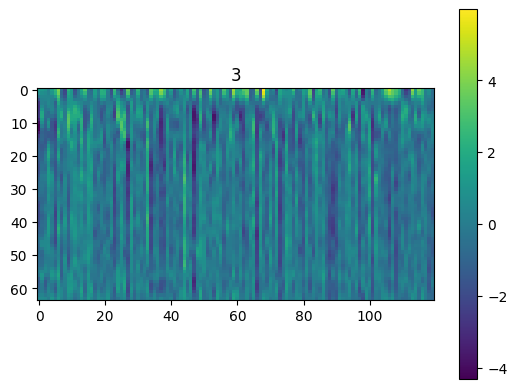

--- block ---
Parameter containing:
tensor([0.6982, 0.7371, 0.7028, 0.6853, 0.7250, 0.7223, 0.7348, 0.6944, 0.7000,
        0.6945, 0.6771, 0.7538, 0.7815, 0.7537, 0.7007, 0.7290, 0.7673, 0.6499,
        0.6779, 0.7703, 0.7709, 0.6713, 0.7028, 0.7374, 0.6868, 0.7025, 0.6814,
        0.7347, 0.6539, 0.7024, 0.6999, 0.7122, 0.7307, 0.7075, 0.6871, 0.6723,
        0.6272, 0.7031, 0.7110, 0.7734, 0.6801, 0.7123, 0.6982, 0.7501, 0.7251,
        0.7580, 0.6783, 0.7288, 0.7495, 0.6863, 0.6351, 0.7302, 0.7414, 0.6610,
        0.7694, 0.7085, 0.6386, 0.7095, 0.6740, 0.7057, 0.7108, 0.7208, 0.7049,
        0.6472, 0.6755, 0.6705, 0.7004, 0.6920, 0.6804, 0.7389, 0.7185, 0.7536,
        0.6584, 0.6778, 0.6991, 0.6869, 0.7543, 0.6220, 0.7165, 0.7735, 0.7198,
        0.7553, 0.7279, 0.7308, 0.7288, 0.7519, 0.6866, 0.7348, 0.7046, 0.7525,
        0.6896, 0.7262, 0.7186, 0.6705, 0.7250, 0.7385, 0.6672, 0.6655, 0.7040,
        0.6885, 0.7456, 0.7028, 0.7220, 0.6823, 0.7180, 0.6579, 0.7323, 0.7086,
    

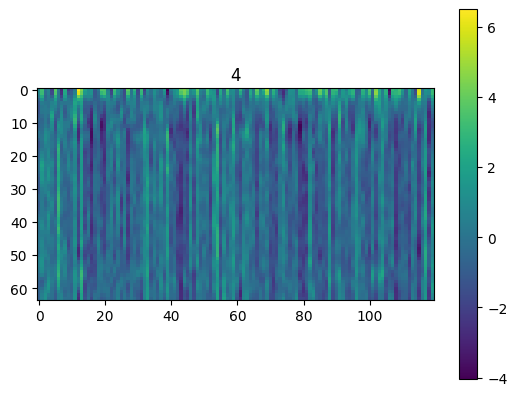

--- block ---
Parameter containing:
tensor([0.6363, 0.7124, 0.7250, 0.6890, 0.6563, 0.7244, 0.6870, 0.6653, 0.7354,
        0.7279, 0.7208, 0.6785, 0.7725, 0.6774, 0.7185, 0.6897, 0.6863, 0.6872,
        0.7009, 0.7192, 0.7405, 0.6475, 0.7112, 0.6636, 0.6974, 0.6968, 0.6925,
        0.7450, 0.6991, 0.7262, 0.7051, 0.6574, 0.7231, 0.7129, 0.6778, 0.7041,
        0.6848, 0.7032, 0.6920, 0.6744, 0.7409, 0.6128, 0.6745, 0.7428, 0.7311,
        0.7351, 0.7123, 0.6321, 0.6134, 0.7013, 0.6895, 0.7149, 0.6435, 0.7189,
        0.7537, 0.7261, 0.7228, 0.6942, 0.7105, 0.7657, 0.6613, 0.6973, 0.7374,
        0.7006, 0.7031, 0.6950, 0.7317, 0.7704, 0.6501, 0.6914, 0.6743, 0.6309,
        0.6891, 0.6907, 0.6340, 0.7206, 0.6860, 0.7108, 0.6979, 0.7243, 0.6930,
        0.6904, 0.7421, 0.6194, 0.6995, 0.7331, 0.7386, 0.7179, 0.6974, 0.7205,
        0.7278, 0.7029, 0.7166, 0.7049, 0.6187, 0.6947, 0.7247, 0.7225, 0.7301,
        0.7002, 0.7450, 0.7365, 0.6367, 0.7335, 0.7157, 0.7015, 0.7356, 0.6869,
    

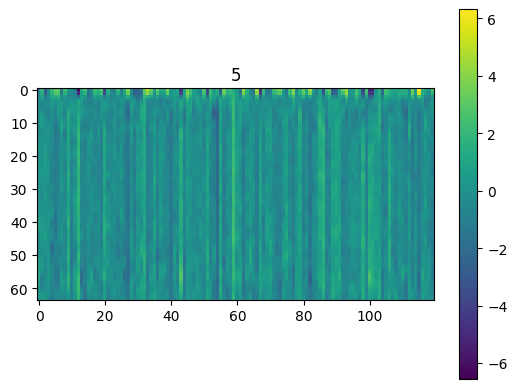

In [18]:
for m307b in models:
    if 'm307b' not in type(m307b.inner).__name__.lower(): continue
    print("===",type(m307b.inner).__name__,"===")
    smear=m307b.inner.gaussian_smear(torch.linspace(0,10,64).to(cuda))
    print(m307b.inner.alpha)
    for i,interaction in enumerate(m307b.inner.convs):
        print("--- block ---")
        print(interaction.alpha)
        tmp=interaction.edge_mlp(smear)
        #tmp_=conv.edge_mlp(torch.linspace(0,6,100).view(-1,1).to(cuda)).softmax(-1).detach()
        ax=imshow(tmp)
        plt.title(i)
        plt.gcf().colorbar(ax)
        #plt.title(f"{load_balancing_loss(tmp,mogin.inner.routing_loss_alpha,mogin.inner.routing_loss_beta,.003).item():.3f} {(mogin.inner.routing_loss_alpha+mogin.inner.routing_loss_beta)*mogin.inner.routing_loss_threshold}")
        plt.show()

=== M307C ===
Parameter containing:
tensor([0.6911, 0.6839, 0.6726, 0.7017, 0.7555, 0.8091], device='cuda:0',
       requires_grad=True)
--- block ---
Parameter containing:
tensor([0.6863, 0.7108, 0.6523, 0.6801, 0.7297, 0.7308, 0.7122, 0.7166, 0.6962,
        0.7190, 0.6769, 0.7523, 0.7121, 0.7142, 0.6716, 0.6390, 0.6905, 0.7175,
        0.6732, 0.7326, 0.6974, 0.6534, 0.6996, 0.6738, 0.7552, 0.6744, 0.7102,
        0.6765, 0.6835, 0.7867, 0.6765, 0.7041, 0.7175, 0.7171, 0.7040, 0.7177,
        0.7333, 0.7790, 0.6821, 0.6491, 0.7472, 0.7043, 0.6947, 0.7538, 0.7128,
        0.6978, 0.6699, 0.6868, 0.7227, 0.6948, 0.7023, 0.7189, 0.7434, 0.6243,
        0.6861, 0.7008, 0.6632, 0.6621, 0.7008, 0.6732, 0.6955, 0.6904, 0.6352,
        0.6887, 0.7306, 0.7114, 0.6678, 0.7417, 0.7024, 0.6876, 0.7078, 0.6155,
        0.7088, 0.6979, 0.6698, 0.6509, 0.6547, 0.7112, 0.7074, 0.6488, 0.7261,
        0.6632, 0.7554, 0.7273, 0.7152, 0.7175, 0.7173, 0.7167, 0.7087, 0.7412,
        0.7128, 0.7269, 0.6

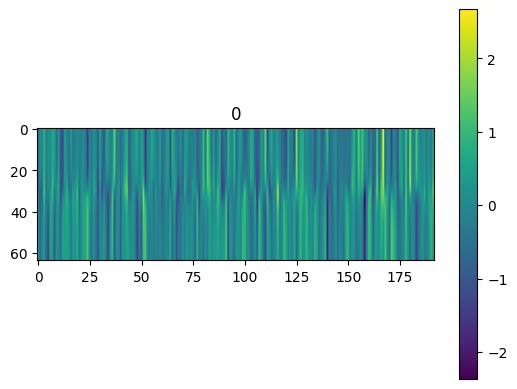

--- block ---
Parameter containing:
tensor([0.7523, 0.7341, 0.6731, 0.7724, 0.7271, 0.6261, 0.6650, 0.7537, 0.6773,
        0.6784, 0.7027, 0.6993, 0.6581, 0.6937, 0.6995, 0.7483, 0.7342, 0.7136,
        0.6901, 0.7526, 0.7188, 0.6774, 0.7004, 0.7230, 0.6776, 0.7238, 0.7484,
        0.6955, 0.7933, 0.7842, 0.7335, 0.6962, 0.6428, 0.6775, 0.7075, 0.6842,
        0.7106, 0.6966, 0.6933, 0.7117, 0.7794, 0.6992, 0.7642, 0.7053, 0.7632,
        0.7261, 0.7436, 0.6935, 0.7042, 0.6326, 0.6795, 0.6460, 0.7000, 0.7309,
        0.6995, 0.6582, 0.7516, 0.6808, 0.7281, 0.6822, 0.7459, 0.7414, 0.7328,
        0.7101, 0.7353, 0.7217, 0.7066, 0.7036, 0.7048, 0.7329, 0.6798, 0.6738,
        0.7366, 0.7669, 0.7166, 0.7482, 0.7461, 0.6469, 0.6833, 0.6817, 0.6920,
        0.6817, 0.7051, 0.7152, 0.6816, 0.6314, 0.7206, 0.7104, 0.6770, 0.6989,
        0.7310, 0.7099, 0.7632, 0.7204, 0.6305, 0.7657, 0.6797, 0.7218, 0.6825,
        0.7695, 0.6968, 0.7043, 0.6943, 0.6969, 0.6806, 0.7783, 0.6461, 0.7396,
    

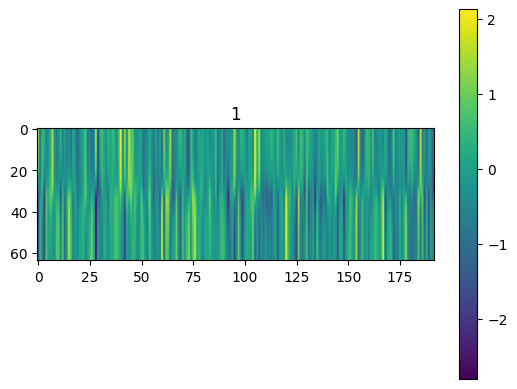

--- block ---
Parameter containing:
tensor([0.7529, 0.7397, 0.7233, 0.7092, 0.7124, 0.7125, 0.7170, 0.6952, 0.7132,
        0.7498, 0.6565, 0.7066, 0.6663, 0.6722, 0.7034, 0.6843, 0.6238, 0.6823,
        0.7653, 0.6842, 0.6853, 0.7111, 0.7189, 0.6734, 0.7160, 0.7118, 0.7356,
        0.6577, 0.6601, 0.6838, 0.7021, 0.7765, 0.7485, 0.6865, 0.6513, 0.6754,
        0.6571, 0.7243, 0.7091, 0.6967, 0.7565, 0.6501, 0.6937, 0.7055, 0.6847,
        0.7097, 0.7293, 0.6943, 0.7323, 0.7358, 0.6991, 0.7489, 0.7310, 0.7246,
        0.6745, 0.6864, 0.7456, 0.6551, 0.6816, 0.7240, 0.7210, 0.7476, 0.7156,
        0.7240, 0.7363, 0.7068, 0.6853, 0.7148, 0.7412, 0.7511, 0.7336, 0.6852,
        0.7069, 0.6870, 0.7084, 0.7172, 0.6724, 0.6999, 0.7124, 0.7195, 0.7134,
        0.7234, 0.6772, 0.6605, 0.7046, 0.7061, 0.7217, 0.7275, 0.6675, 0.7022,
        0.7086, 0.7235, 0.6932, 0.6951, 0.7037, 0.7284, 0.7287, 0.7125, 0.6899,
        0.7175, 0.6982, 0.7125, 0.6905, 0.6909, 0.6790, 0.6939, 0.7317, 0.6977,
    

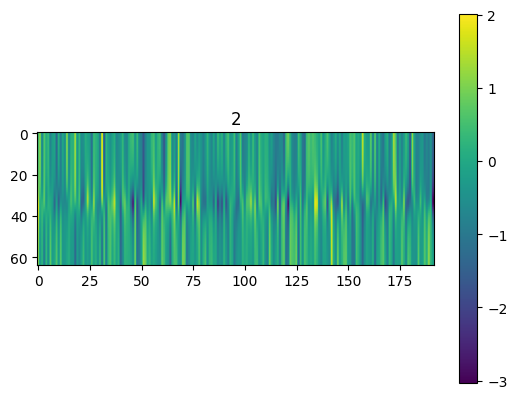

--- block ---
Parameter containing:
tensor([0.7078, 0.7333, 0.7017, 0.7118, 0.7448, 0.5649, 0.7230, 0.7279, 0.7152,
        0.7150, 0.7333, 0.7425, 0.6748, 0.5850, 0.7118, 0.6552, 0.6827, 0.6713,
        0.7709, 0.7228, 0.7117, 0.7113, 0.7453, 0.6415, 0.7155, 0.7153, 0.7662,
        0.7503, 0.7073, 0.7471, 0.7221, 0.6606, 0.5561, 0.6667, 0.7333, 0.7159,
        0.6905, 0.7589, 0.6691, 0.7499, 0.6947, 0.6398, 0.7141, 0.7239, 0.7156,
        0.7092, 0.7247, 0.7760, 0.7448, 0.7398, 0.7110, 0.7033, 0.7237, 0.6531,
        0.7010, 0.7224, 0.6236, 0.7153, 0.6264, 0.7088, 0.7253, 0.6545, 0.7189,
        0.7119, 0.7092, 0.6827, 0.7337, 0.7482, 0.7206, 0.7111, 0.6948, 0.7369,
        0.7225, 0.7314, 0.6009, 0.6988, 0.7000, 0.7472, 0.7082, 0.7173, 0.6789,
        0.6954, 0.6475, 0.7091, 0.7357, 0.6472, 0.7008, 0.6407, 0.6884, 0.7194,
        0.7141, 0.6862, 0.7236, 0.7285, 0.6665, 0.6798, 0.7077, 0.7377, 0.7268,
        0.7436, 0.7165, 0.6309, 0.6783, 0.7187, 0.6932, 0.7004, 0.6979, 0.7021,
    

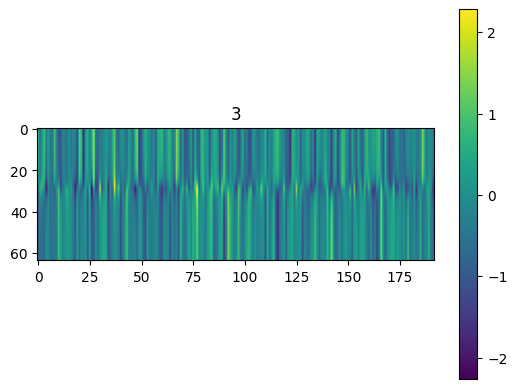

--- block ---
Parameter containing:
tensor([0.7466, 0.7191, 0.6238, 0.6802, 0.6722, 0.6915, 0.6694, 0.7364, 0.6806,
        0.7372, 0.6978, 0.7218, 0.7358, 0.6709, 0.7229, 0.6533, 0.6435, 0.7236,
        0.6984, 0.7505, 0.6922, 0.7155, 0.7501, 0.6888, 0.7038, 0.6744, 0.6563,
        0.7216, 0.7391, 0.7222, 0.6729, 0.7299, 0.7396, 0.6943, 0.6632, 0.7133,
        0.6390, 0.7073, 0.6690, 0.6711, 0.6351, 0.5831, 0.6822, 0.6672, 0.7146,
        0.7220, 0.6337, 0.7130, 0.7427, 0.6574, 0.6869, 0.7126, 0.7157, 0.6995,
        0.6658, 0.7170, 0.7046, 0.7071, 0.6878, 0.7250, 0.6683, 0.6362, 0.6629,
        0.7164, 0.7134, 0.6981, 0.6637, 0.7074, 0.7188, 0.7335, 0.7072, 0.6974,
        0.6847, 0.7055, 0.6990, 0.7139, 0.6199, 0.7057, 0.7239, 0.7092, 0.6871,
        0.6972, 0.6689, 0.6765, 0.6617, 0.7118, 0.6479, 0.7335, 0.6439, 0.7220,
        0.6964, 0.7027, 0.7441, 0.7047, 0.6633, 0.7114, 0.6704, 0.7016, 0.6578,
        0.6600, 0.6678, 0.7134, 0.6392, 0.7388, 0.7275, 0.7089, 0.7004, 0.7031,
    

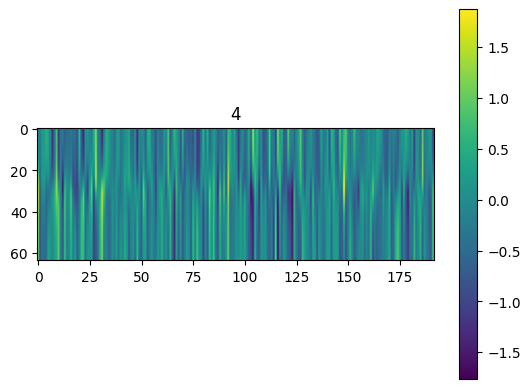

--- block ---
Parameter containing:
tensor([0.7153, 0.7024, 0.7130, 0.6524, 0.6790, 0.7110, 0.6884, 0.6604, 0.6556,
        0.6728, 0.7126, 0.7003, 0.7086, 0.6813, 0.6975, 0.7093, 0.6138, 0.6784,
        0.6608, 0.6301, 0.6382, 0.6441, 0.6586, 0.6579, 0.6964, 0.6967, 0.6898,
        0.6888, 0.7049, 0.7016, 0.7034, 0.6851, 0.5944, 0.6977, 0.6902, 0.7041,
        0.6835, 0.7213, 0.7069, 0.6832, 0.6930, 0.6845, 0.7131, 0.7043, 0.7027,
        0.7073, 0.4303, 0.6652, 0.6077, 0.7137, 0.7046, 0.6510, 0.7247, 0.7159,
        0.5575, 0.7221, 0.6960, 0.7243, 0.6940, 0.7118, 0.6656, 0.6771, 0.7032,
        0.6877, 0.6744, 0.7116, 0.7496, 0.6728, 0.7039, 0.6664, 0.6991, 0.6891,
        0.6377, 0.5561, 0.7221, 0.6737, 0.6898, 0.5629, 0.6932, 0.6991, 0.6862,
        0.6848, 0.7118, 0.6760, 0.6913, 0.6983, 0.6808, 0.6927, 0.6478, 0.6808,
        0.6705, 0.6372, 0.6984, 0.7175, 0.6804, 0.7013, 0.7061, 0.7015, 0.6807,
        0.6866, 0.7037, 0.6836, 0.6680, 0.6195, 0.7760, 0.7572, 0.7275, 0.5809,
    

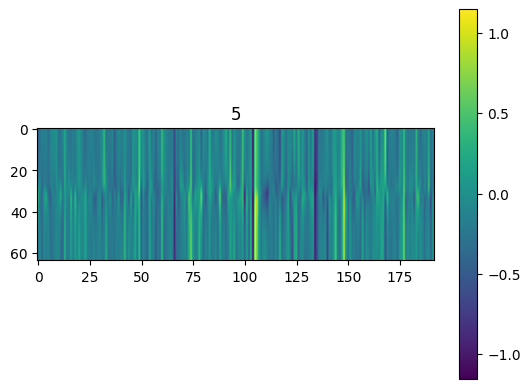

In [21]:
for m307c in models:
    if 'm307c' not in type(m307c.inner).__name__.lower(): continue
    print("===",type(m307c.inner).__name__,"===")
    smear=torch.linspace(-1,1,64).to(cuda).view(-1,1)
    print(m307c.inner.alpha)
    for i,interaction in enumerate(m307c.inner.convs):
        print("--- block ---")
        print(interaction.alpha)
        tmp=interaction.edge_mlp(smear)
        #tmp_=conv.edge_mlp(torch.linspace(0,6,100).view(-1,1).to(cuda)).softmax(-1).detach()
        ax=imshow(tmp)
        plt.title(i)
        plt.gcf().colorbar(ax)
        #plt.title(f"{load_balancing_loss(tmp,mogin.inner.routing_loss_alpha,mogin.inner.routing_loss_beta,.003).item():.3f} {(mogin.inner.routing_loss_alpha+mogin.inner.routing_loss_beta)*mogin.inner.routing_loss_threshold}")
        plt.show()

=== MoGIN14 ===


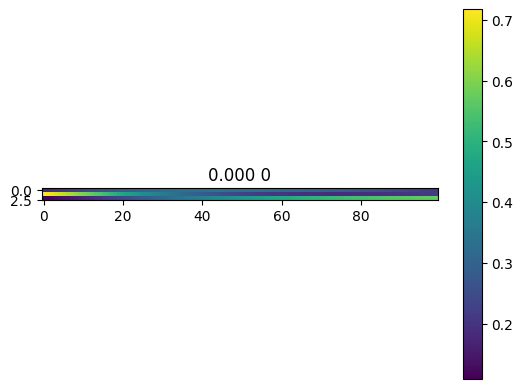

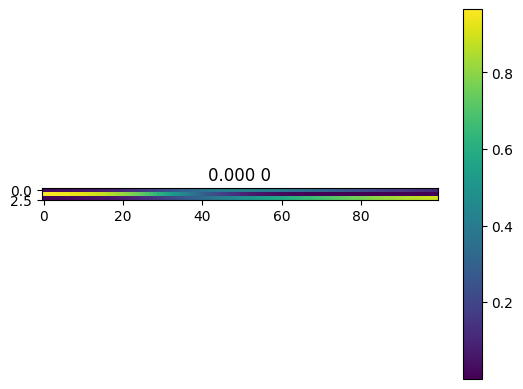

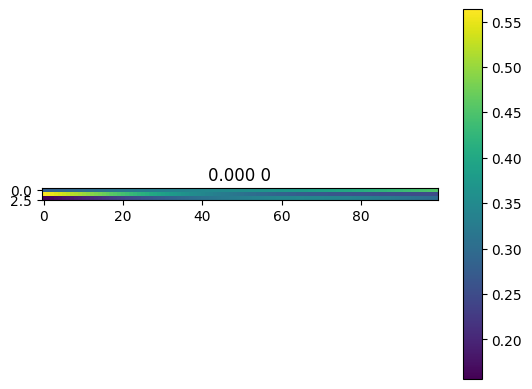

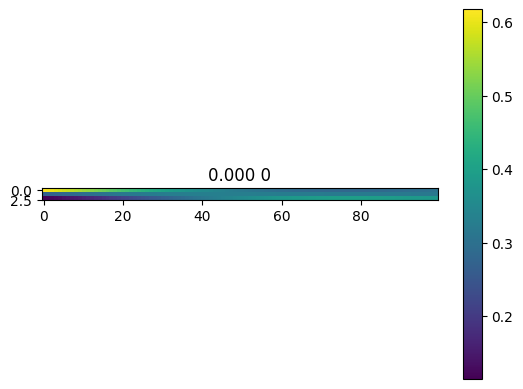

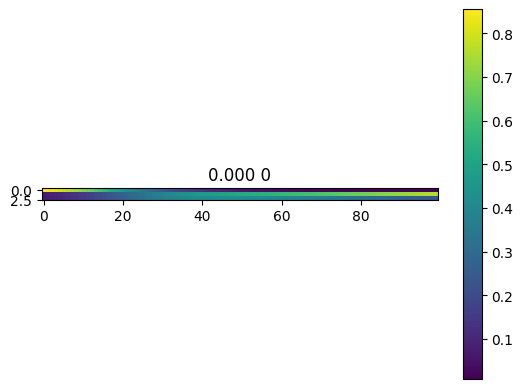

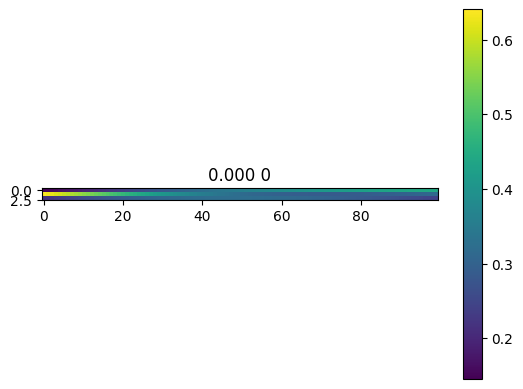

=== MoGIN16 ===


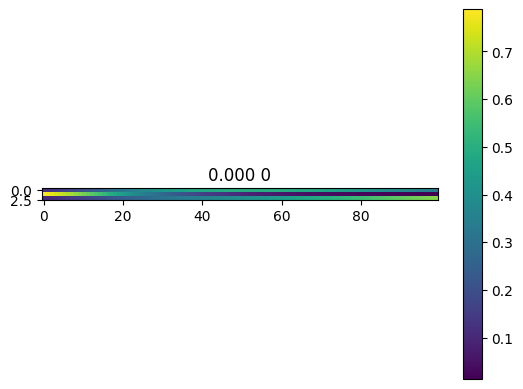

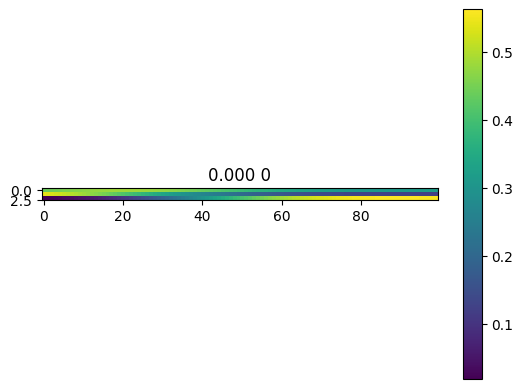

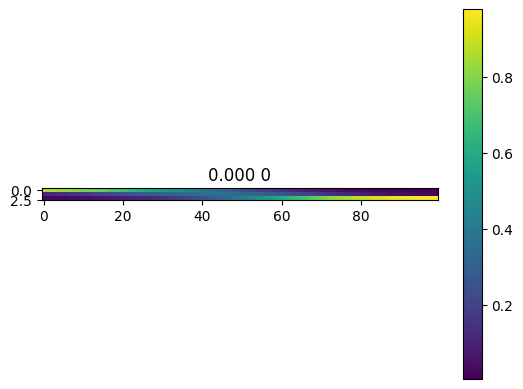

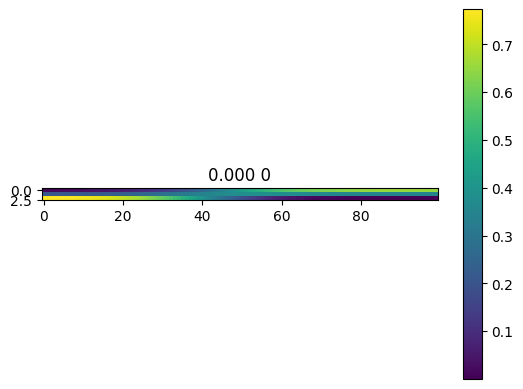

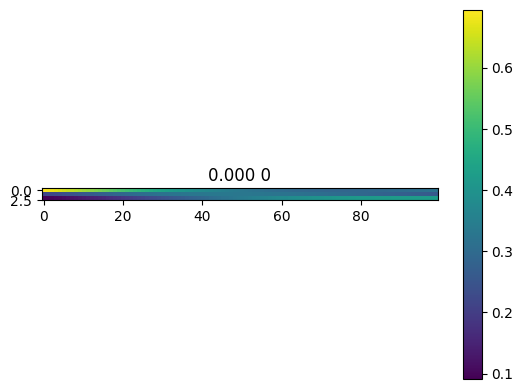

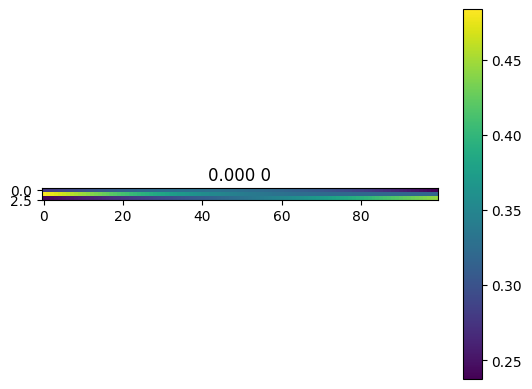

In [35]:
for mogin in models:
    if 'MoGIN' not in type(mogin.inner).__name__: continue
    print("===",type(mogin.inner).__name__,"===")
    for conv in mogin.inner.convs:
        tmp=conv.router_mlp(torch.linspace(-10,10,100).view(-1,1).to(cuda)).softmax(-1).detach()
        ax=imshow(tmp.T)
        plt.gcf().colorbar(ax)
        plt.title(f"{float(load_balancing_loss(tmp,mogin.inner.routing_loss_alpha,mogin.inner.routing_loss_beta,.003)):.3f} {(mogin.inner.routing_loss_alpha+mogin.inner.routing_loss_beta)*mogin.inner.routing_loss_threshold}")
        plt.show()

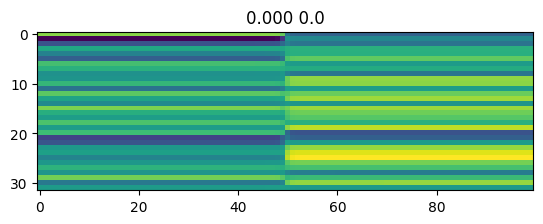

In [34]:
tmp=mogin.inner.convs[0].edge_mlp(torch.linspace(-2,2,100).view(-1,1).to(cuda)).detach()
plt.imshow(tmp.cpu().numpy().T)
plt.title(f"{float(load_balancing_loss(tmp,mogin.inner.routing_loss_alpha,mogin.inner.routing_loss_beta,.003)):.3f} {(mogin.inner.routing_loss_alpha+mogin.inner.routing_loss_beta)*mogin.inner.routing_loss_threshold}")
plt.show()

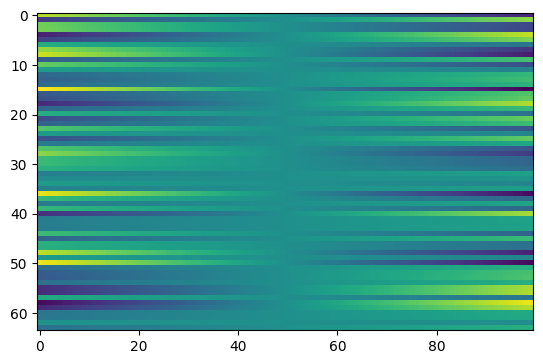

In [56]:
tmp=mogin.inner.convs[0].edge_mlp.lins[0](torch.linspace(-4,4,100).view(-1,1).to(cuda)).detach()
imshow(tmp.T)

In [ ]:
for conv in mogin.inner.convs:
    tmp=conv.edge_mlp(torch.linspace(-6,6,100).view(-1,1).to(cuda)).detach()
    plt.imshow(tmp.cpu().numpy().T)
    plt.title(f"{float(load_balancing_loss(tmp,mogin.inner.routing_loss_alpha,mogin.inner.routing_loss_beta,.003)):.3f} {(mogin.inner.routing_loss_alpha+mogin.inner.routing_loss_beta)*mogin.inner.routing_loss_threshold}")
    plt.show()

In [17]:
from pathlib import Path

In [30]:
Path("C:/Users/umarzein/Desktop/biocheminformatics/saves")==Path("./saves/")

False

In [28]:
!pwd

/c/Users/umarzein/Desktop/biocheminformatics


In [31]:
len(list(Path("C:/Users/umarzein/Desktop/biocheminformatics/saves").iterdir()))

3840

In [33]:
tmp=next(Path("./saves/").iterdir())
tmp

WindowsPath('saves/DRGIN-0098e4')

In [42]:
tmp.name

'DRGIN-0098e4'

In [40]:
from models.schnet import SchNet

In [43]:
m=TrainingContext.load('SchNet-0003b0', SchNet)

In [49]:
m.

{'hidden_channels': 128,
 'num_filters': 128,
 'num_interactions': 6,
 'num_gaussians': 50,
 'cutoff': 10.0,
 'interaction_graph': None,
 'max_num_neighbors': 32,
 'readout': 'add',
 'dipole': False,
 'mean': None,
 'std': None,
 'atomref': None}

In [7]:

    from tqdm.auto import tqdm

0it [00:00, ?it/s]

find_first_eval_loss_record SchNet
find_first_eval_loss_record M305A
find_first_eval_loss_record M305B
find_first_eval_loss_record M304A
find_first_eval_loss_record M304B
find_first_eval_loss_record MoGIN14
find_first_eval_loss_record SchNetMinim
find_first_eval_loss_record SchNetGeneralized


In [12]:
{
    k:type(v) for k,v in out.items()
}

{models.schnet.SchNet: NoneType,
 models.m305a.M305A: NoneType,
 models.m305b.M305B: NoneType,
 models.m304a.M304A: NoneType,
 models.m304b.M304B: NoneType,
 models.mogin14.MoGIN14: NoneType,
 models.schnet_minim.SchNetMinim: NoneType,
 models.schnet_generalized.SchNetGeneralized: NoneType}

In [86]:
out=find_first_eval_loss_record(SchNet,mean=2)
out

  0%|          | 0/1443 [00:00<?, ?it/s]

In [68]:
m.inner.get_config()

{'hidden_channels': 128,
 'num_filters': 128,
 'num_interactions': 6,
 'num_gaussians': 50,
 'cutoff': 10.0,
 'interaction_graph': None,
 'max_num_neighbors': 32,
 'readout': 'add',
 'dipole': False,
 'mean': None,
 'std': None,
 'atomref': None}

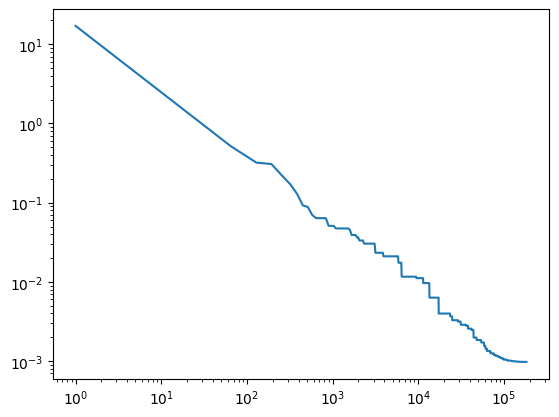

In [65]:
out.cummin().plot()
plt.xscale('log')
plt.yscale('log')

In [163]:
from tqdm.auto import tqdm
mogin_best_loss={}
tmp=tqdm(os.walk('./saves'))
for root, dirs, files  in tmp:
    if 'MoGIN11' not in root: continue
    name=root.split('\\')[-1]
    tmp.set_description(name)
    #print('===')
    #print(root)
    ckpt=torch.load(f"saves/{name}/checkpoint.pth")
    loss_rec=ckpt['loss_record']['test']
    best_eval_loss=min(loss_rec.values())
    #print(name,best_eval_loss)
    mogin_best_loss[name]=best_eval_loss

0it [00:00, ?it/s]

In [164]:
mogin_best_loss_srs=pd.Series(mogin_best_loss)

In [166]:
mogin_best_loss_srs.sort_values()

MoGIN11-6c4240    0.001622
MoGIN11-046215    0.001624
MoGIN11-493d77    0.001629
MoGIN11-6a5f35    0.001631
MoGIN11-ba76bf    0.001632
                    ...   
MoGIN11-d7222e    0.096079
MoGIN11-d8e0b1    0.224504
MoGIN11-a67fc5    0.710080
MoGIN11-f032b5    0.886633
MoGIN11-84de2e    3.522904
Length: 298, dtype: float64

In [16]:
len(models)

4

In [17]:
import numpy as np
BATCH_SIZE=64
N_EPOCHS=100
N_mols=len(train_dataset)
long_bar=tqdm(range(N_EPOCHS*N_mols//BATCH_SIZE),smoothing=0)
e_bar=tqdm(range(N_mols//BATCH_SIZE),smoothing=0)
Q=10000
N_TRAINING_MODEL=len(models)
for model in models:
    model.inner=model.inner.train()
    model.stopped=False
    
#torch.autograd.set_detect_anomaly(True)
for epoch in range(N_EPOCHS):
    e_bar.refresh()
    e_bar.reset(N_mols//BATCH_SIZE)
    train_bl=DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    for i, batch in zip(range(N_mols//BATCH_SIZE), train_bl):
        long_bar.update(1)
        e_bar.update(1)
        
        try:
            batch=(batch.to(cuda))
            y=(batch[YCOL]-__mean)/__std
            
            for model in models:
                if model.stopped or not model.training: continue
                model.inner=model.inner.train()
                out = model.inner(batch)
                extra_loss=0
                if isinstance(out, tuple):
                    out, extra_loss=out
                loss = ((out-y)**2).mean()+extra_loss
                model.inner.zero_grad(set_to_none=True)
                
                if model.total_iters<5:
                    model.running_loss = model.running_loss*.3+loss.item()*.7
                else:
                    model.running_loss = model.running_loss*(1-1/100)+loss.item()/100
                    
                if model.total_iters+.2>1.1**len(model.train_loss_record):
                    model.train_loss_record[model.total_iters]=model.running_loss
                loss.backward()
                model.optim.step()
                model.total_iters+=1

            ### evaluation
            if i%64==0:
                for model in models:
                    if model.stopped or not model.training: continue
                    model.inner=model.inner.eval()
                    L=len(test_dataset)
                    test_bl=DataLoader(test_dataset, batch_size=L)
                    all_eval_y=list()
                    model.test_loss_record[model.total_iters]=0
                    for batch in test_bl:
                        batch=(batch.to(cuda))
                        eval_y=(batch[YCOL]-__mean)/__std
                        all_eval_y+=eval_y.view(-1).tolist()
                        with torch.no_grad():
                            out = model.inner(batch)#X, A, E, batch=b)
                            if isinstance(out, tuple):
                                out, _=out
                        model.results=out.view(-1).tolist()
                        loss = ((out-eval_y).abs()).sum().detach().item()
                        model.test_loss_record[model.total_iters]+=loss/L
                    
                    if model.test_loss_record[model.total_iters]<model.best_eval_loss:
                        model.best_eval_loss=model.test_loss_record[model.total_iters]
                        if model.total_iters>10000:
                            model.save()
                        #if np.log10(loss/models[model_name]['best_eval_loss'])>1.5 and models[model_name]['total_iters']>100:
                        #    models[model_name]['stopped']=True
                        #    N_TRAINING_MODEL-=1
            ###logging
            logstr=''
            for model in models:
                if model.stopped:
                    logstr+=f'{model.name}(stopped):{int(Q*model.running_loss)/Q}({int(Q*model.best_eval_loss)/Q}). '
                else:
                    logstr+=f'{model.name}:{int(Q*model.running_loss)/Q}({int(Q*model.best_eval_loss)/Q}). '
            e_bar.set_description(logstr)
        except Exception as e:
            raise e
    ### stepping schedulers:
    
    for model in models:
        if model.sched is None: continue
        if model.stopped or not model.training: continue
        model.inner=model.inner.eval()
        L=len(test_dataset)
        test_bl=DataLoader(test_dataset, batch_size=L)
        total_eval_loss=0
        for batch in test_bl:
            batch=(batch.to(cuda))
            eval_y=(batch[YCOL]-__mean)/__std
            with torch.no_grad():
                out = model.inner(batch)#X, A, E, batch=b)
                if isinstance(out, tuple):
                    out, _=out
            loss = ((out-eval_y).abs()).sum().detach().item()
            total_eval_loss+=loss/L
        model.sched.step()

  0%|          | 0/206598 [00:00<?, ?it/s]

  0%|          | 0/2065 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
pd.Series(model.test_loss_record).cummin()

1         0.745479
65        0.274820
129       0.172408
193       0.172408
257       0.095303
            ...   
128927    0.001067
128991    0.001067
129055    0.001067
129119    0.001067
129183    0.001067
Length: 2065, dtype: float64

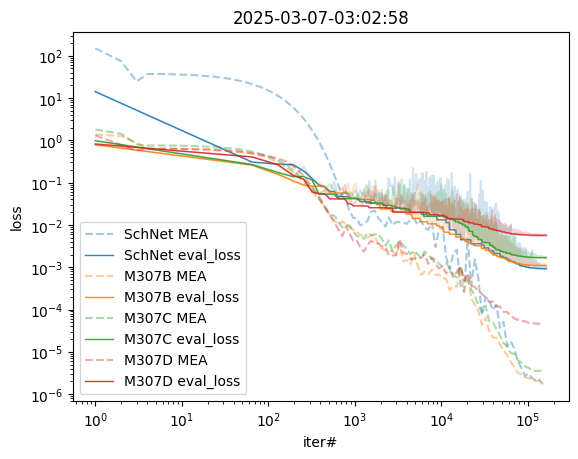

In [18]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
for model,c in zip(models,['tab:'+cn for cn in ('blue','orange','green','red','purple','brown','pink','gray','olive','cyan')]):
    plt.plot(pd.Series(model.train_loss_record),label=model.name+' MEA',linestyle='--',alpha=0.4,c=c)
    plt.plot(pd.Series(model.test_loss_record),alpha=0.2,c=c)
    plt.plot(pd.Series(model.test_loss_record).cummin(),label=model.name+' eval_loss',alpha=0.9,c=c,lw=1)
    
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

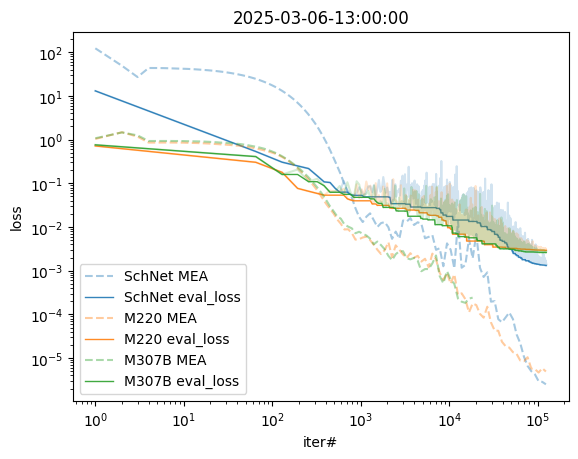

In [84]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
for model,c in zip(models,['tab:'+cn for cn in ('blue','orange','green','red','purple','brown','pink','gray','olive','cyan')]):
    plt.plot(pd.Series(model.train_loss_record),label=model.name+' MEA',linestyle='--',alpha=0.4,c=c)
    plt.plot(pd.Series(model.test_loss_record),alpha=0.2,c=c)
    plt.plot(pd.Series(model.test_loss_record).cummin(),label=model.name+' eval_loss',alpha=0.9,c=c,lw=1)
    
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

In [42]:
models[1].inner.alpha

Parameter containing:
tensor([0.8100, 0.8230, 0.8475, 0.8367, 0.8220, 0.8950], device='cuda:0',
       requires_grad=True)

In [47]:
def auto_save_hyperparams(init_fn):
    import inspect
    def wrapper(self, *args, **kwargs):
        # Bind the arguments to the function signature and apply defaults
        sig = inspect.signature(init_fn)
        bound_args = sig.bind(self, *args, **kwargs)
        bound_args.apply_defaults()
        # Save all parameters except 'self'
        self.hparams = {
            name: value 
            for name, value in bound_args.arguments.items() 
            if name != "self"
        }
        return init_fn(self, *args, **kwargs)
    return wrapper

In [39]:
class Test(nn.Module):
    @auto_save_hyperparams
    def __init__(self, a, b, c):
        super().__init__()
        self.x=a+b+c

In [48]:
test=Test(1,2,3)
test.training

True

In [ ]:
len(all_eval_y)

In [ ]:
radius_graph(batch.pos,10)

In [101]:
test.inner=test.inner.eval()
test_bl=DataLoader(test_dataset, batch_size=1024)
total_eval_loss=0
for batch in test_bl:
    batch=(batch.to(cuda))
    eval_y=(batch[YCOL]-__mean)/__std
    with torch.no_grad():
        out = test.inner(batch)#X, A, E, batch=b)
        if isinstance(out, tuple):
            out, _=out
    loss = ((out-eval_y).abs()).sum().detach().item()
    total_eval_loss+=loss/len(eval_y)

In [85]:
test_bl=DataLoader(test_dataset, batch_size=L)
for batch in test_bl:
    batch=(batch.to(cuda))
batch

MolDataBatch(edge_index=[2, 28279], pos=[9013, 3], atom_type=[9013], edge_type=[28279], dist=[28279, 1], D=[28279, 3], U=[28279, 3], V=[28279, 3], logp=[1024], C=[1024], zpve=[1024], u0=[1024], gap=[1024], B=[1024], homo=[1024], mu=[1024], A=[1024], r2=[1024], u298_atom=[1024], u0_atom=[1024], u298=[1024], lumo=[1024], g298=[1024], h298=[1024], cv=[1024], g298_atom=[1024], h298_atom=[1024], alpha=[1024], dest=[20688], inbound=[20688, 2], ang_deltas=[20688], anchor_ang=[20688], batch=[9013], ptr=[1025])

In [117]:
import sys
sys.prefix

'C:\\Users\\umarzein\\micromamba\\envs\\drugresearch'

(tensor(2.7201, device='cuda:0'), tensor(1.0903, device='cuda:0'))

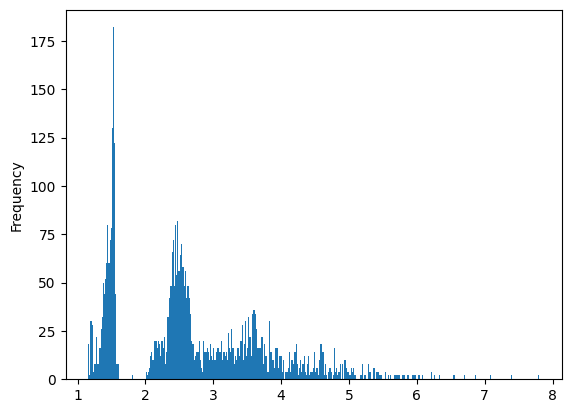

In [31]:
tmp=radius_graph(batch.pos,r=10,batch=batch.batch)
#tmp,_=add_self_loops(tmp)
tmp=batch.pos[tmp]
tmp=(tmp[0]-tmp[1]).norm(p=2,dim=-1)
#tmp=tmp[tmp>0]
#tmp=tmp[tmp<1.65]
pd.Series(tmp.cpu()).plot.hist(bins=400)
tmp.mean(),tmp.std()

In [20]:
#MoGIN4
for model in models:
    print(model.name,model.best_eval_loss,width*model.best_eval_loss,model.sched.state_dict()['_last_lr'])

SchNet 0.007720244582742453 1.747681049497678 [0.0002612799806597893]
MoGIN14 0.012434222735464573 2.814814376293389 [0.0001442331451208257]
MoGIN11 0.03842402249574661 8.698291257688908 [1.911854365927518e-10]


In [29]:
for model in models:
    print(model.name,
          model.best_eval_loss,
          width*model.best_eval_loss
         )

SchNet 0.0009239580249413848 0.20916227632619164
M307B 0.0011005831183865666 0.24914602624130733
M307C 0.0016877322923392057 0.38206273290097187
M307D 0.005697151646018028 1.2897005867038565


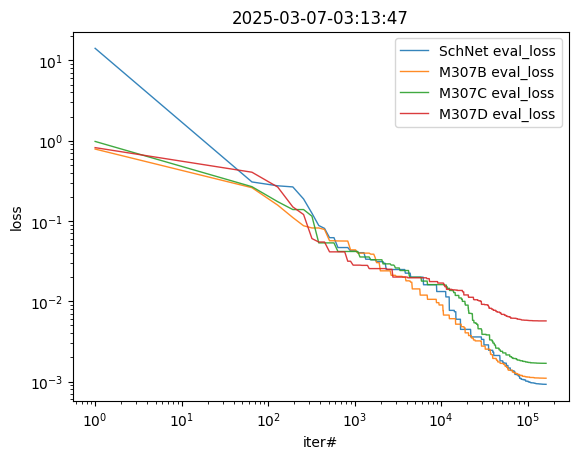

In [20]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
for model,c in zip(models,['tab:'+cn for cn in ('blue','orange','green','red','purple','brown','pink','gray','olive','cyan')]):
    #plt.plot(pd.Series(model.train_loss_record),label=model.name+' MEA',linestyle='--',alpha=0.4,c=c)
    #plt.plot(pd.Series(model.test_loss_record),alpha=0.2,c=c)
    plt.plot(pd.Series(model.test_loss_record).cummin(),label=model.name+' eval_loss',alpha=0.9,c=c,lw=1)
    
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record_cummin-{tsfs}.svg")

Text(0.5, 0, 'iter#')

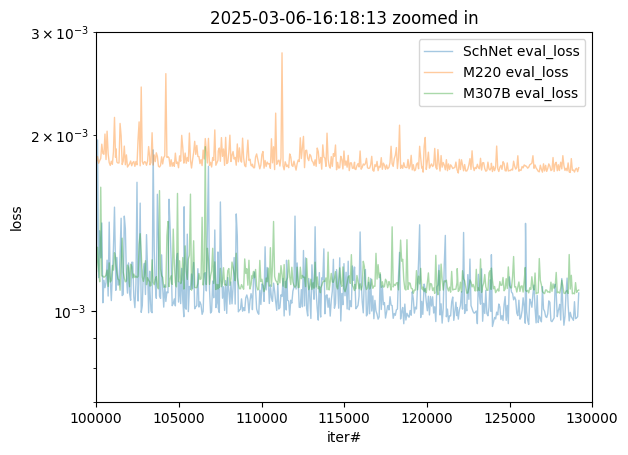

In [28]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
for model,c in zip(models,['tab:'+cn for cn in ('blue','orange','green','red','purple','brown','pink','gray','olive','cyan')]):
    #plt.plot(pd.Series(model.train_loss_record),label=model.name+' MEA',linestyle='--',alpha=0.4,c=c)
    #plt.plot(pd.Series(model.test_loss_record),alpha=0.2,c=c)
    #plt.plot(pd.Series(model.test_loss_record).cummin(),label=model.name+' eval_loss',alpha=0.9,c=c,lw=1)
    plt.plot(pd.Series(model.test_loss_record),label=model.name+' eval_loss',alpha=0.4,c=c,lw=1)
    
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
#plt.xscale('log')
plt.legend()
plt.title(f"{ts} zoomed in")
plt.xlim(100_000,130_000)
plt.ylim(7e-4,3e-3)
plt.ylabel("loss")
plt.xlabel("iter#")
#plt.gcf().savefig(f"loss_record-{tsfs}.svg")

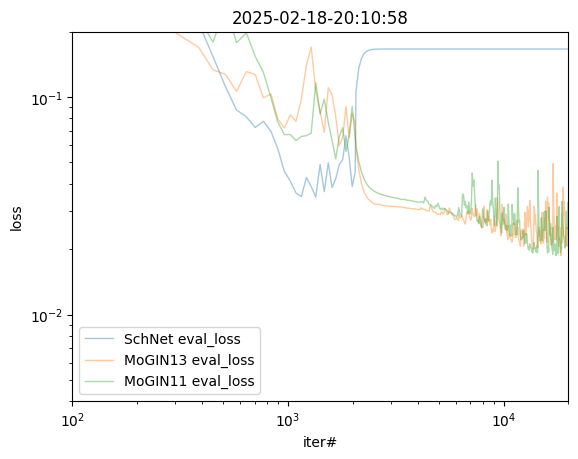

In [101]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
for model,c in zip(models,['tab:'+cn for cn in ('blue','orange','green','red','purple','brown','pink','gray','olive','cyan')]):
    #plt.plot(pd.Series(model.train_loss_record),label=model.name+' MEA',linestyle='--',alpha=0.4,c=c)
    #plt.plot(pd.Series(model.test_loss_record),alpha=0.2,c=c)
    #plt.plot(pd.Series(model.test_loss_record).cummin(),label=model.name+' eval_loss',alpha=0.9,c=c,lw=1)
    plt.plot(pd.Series(model.test_loss_record).ewm(1.0).mean(),label=model.name+' eval_loss',alpha=0.4,c=c,lw=1)
    
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.xlim(100,20_000)
plt.ylim(0.004,0.2)
plt.ylabel("loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

In [21]:
len(models)

4

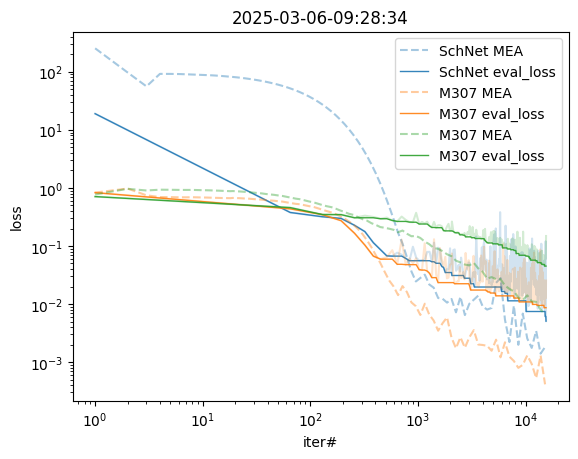

In [21]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
for model,c in zip(models,['tab:'+cn for cn in ('blue','orange','green','red','purple','brown','pink','gray','olive','cyan')]):
    plt.plot(pd.Series(model.train_loss_record),label=model.name+' MEA',linestyle='--',alpha=0.4,c=c)
    plt.plot(pd.Series(model.test_loss_record),alpha=0.2,c=c)
    plt.plot(pd.Series(model.test_loss_record).cummin(),label=model.name+' eval_loss',alpha=0.9,c=c,lw=1)
    
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

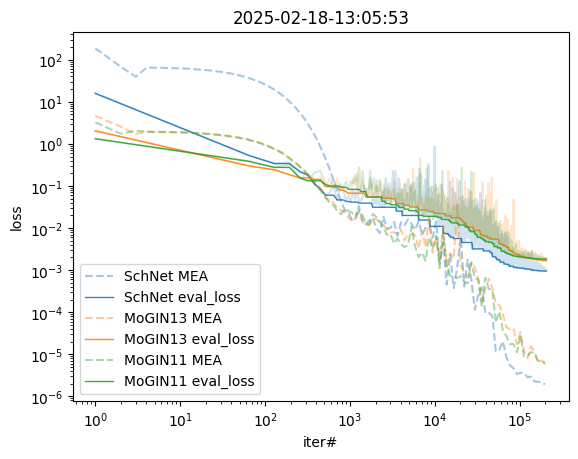

In [25]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
for model,c in zip(models,['tab:'+cn for cn in ('blue','orange','green','red','purple','brown','pink','gray','olive','cyan')]):
    plt.plot(pd.Series(model.train_loss_record),label=model.name+' MEA',linestyle='--',alpha=0.4,c=c)
    plt.plot(pd.Series(model.test_loss_record),alpha=0.2,c=c)
    plt.plot(pd.Series(model.test_loss_record).cummin(),label=model.name+' eval_loss',alpha=0.9,c=c,lw=1)
    
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

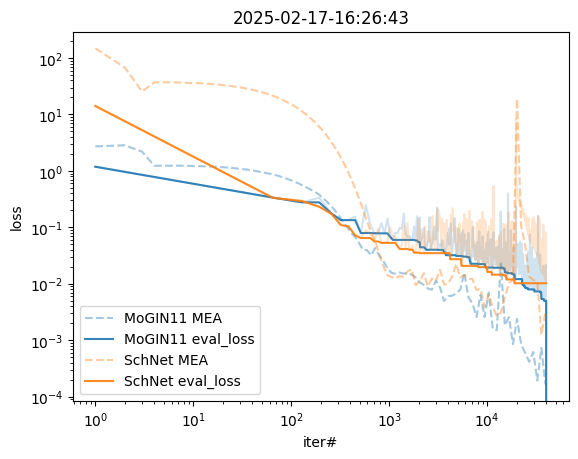

In [60]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
for model,c in zip(models,['tab:'+cn for cn in ('blue','orange','green','red','purple','brown','pink','gray','olive','cyan')]):
    plt.plot(pd.Series(model.train_loss_record),label=model.name+' MEA',linestyle='--',alpha=0.4,c=c)
    plt.plot(pd.Series(model.test_loss_record),alpha=0.2,c=c)
    plt.plot(pd.Series(model.test_loss_record).cummin(),label=model.name+' eval_loss',alpha=0.9,c=c)
    
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

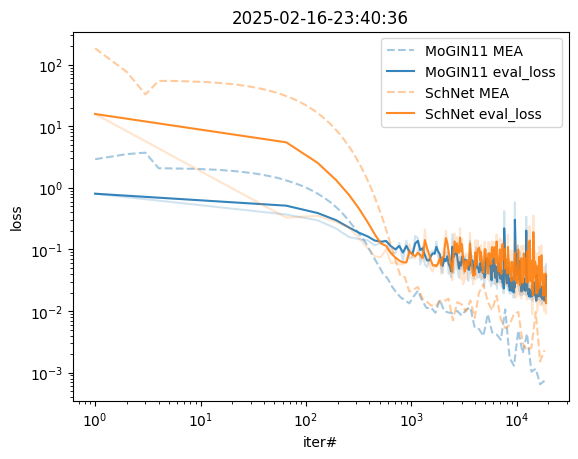

In [33]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
for model,c in zip(models,['tab:'+cn for cn in ('blue','orange','green','red','purple','brown','pink','gray','olive','cyan')]):
    plt.plot(pd.Series(model.train_loss_record),label=model.name+' MEA',linestyle='--',alpha=0.4,c=c)
    plt.plot(pd.Series(model.test_loss_record),alpha=0.2,c=c)
    plt.plot(pd.Series(model.test_loss_record).ewm(0.999).mean(),label=model.name+' eval_loss',alpha=0.9,c=c)
    
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

Text(0.5, 0, 'iter#')

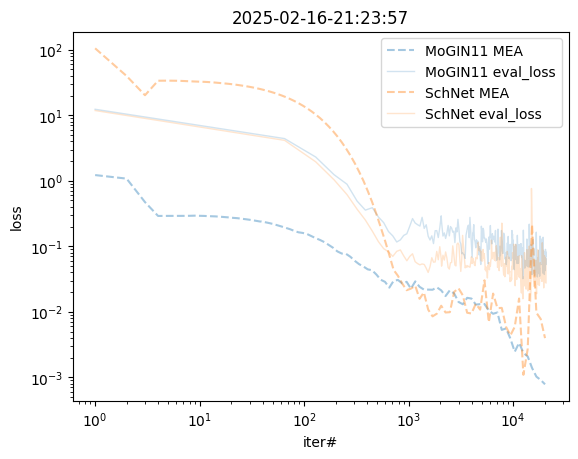

In [100]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
for model,c in zip(models,['tab:'+cn for cn in ('blue','orange','green','red','purple','brown','pink','gray','olive','cyan')]):
    plt.plot(pd.Series(model.train_loss_record),label=model.name+' MEA',linestyle='--',alpha=0.4,c=c)
    #plt.plot(pd.Series(model.test_loss_record),alpha=0.2,c=c)
    plt.plot(pd.Series(model.test_loss_record).ewm(1-1e-10).mean(),label=model.name+' eval_loss',alpha=0.2,lw=1,c=c)
    
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("loss")
plt.xlabel("iter#")
#plt.gcf().savefig(f"loss_record-{tsfs}.svg")

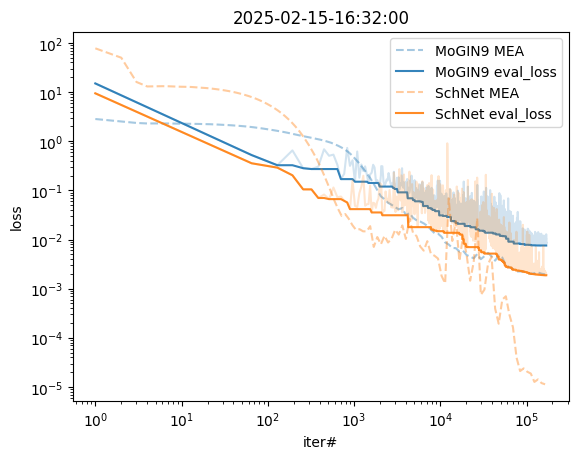

In [84]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
for model,c in zip(models,['tab:'+cn for cn in ('blue','orange','green','red','purple','brown','pink','gray','olive','cyan')]):
    plt.plot(pd.Series(model.train_loss_record),label=model.name+' MEA',linestyle='--',alpha=0.4,c=c)
    plt.plot(pd.Series(model.test_loss_record),alpha=0.2,c=c)
    plt.plot(pd.Series(model.test_loss_record).cummin(),label=model.name+' eval_loss',alpha=0.9,c=c)
    
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

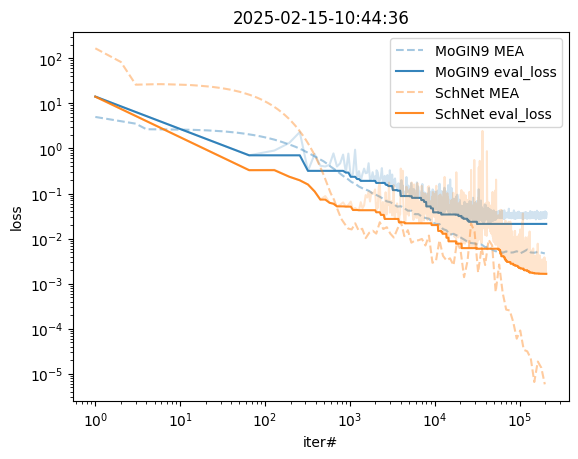

In [60]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
for model,c in zip(models,['tab:'+cn for cn in ('blue','orange','green','red','purple','brown','pink','gray','olive','cyan')]):
    plt.plot(pd.Series(model.train_loss_record),label=model.name+' MEA',linestyle='--',alpha=0.4,c=c)
    plt.plot(pd.Series(model.test_loss_record),alpha=0.2,c=c)
    plt.plot(pd.Series(model.test_loss_record).cummin(),label=model.name+' eval_loss',alpha=0.9,c=c)
    
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

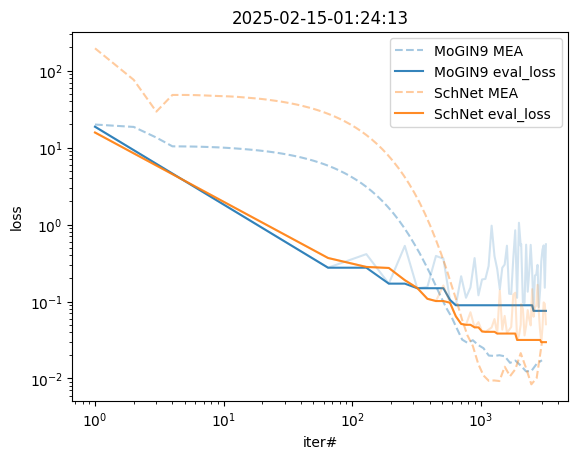

In [42]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
for model,c in zip(models,['tab:'+cn for cn in ('blue','orange','green','red','purple','brown','pink','gray','olive','cyan')]):
    plt.plot(pd.Series(model.train_loss_record),label=model.name+' MEA',linestyle='--',alpha=0.4,c=c)
    plt.plot(pd.Series(model.test_loss_record),alpha=0.2,c=c)
    plt.plot(pd.Series(model.test_loss_record).cummin(),label=model.name+' eval_loss',alpha=0.9,c=c)
    
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

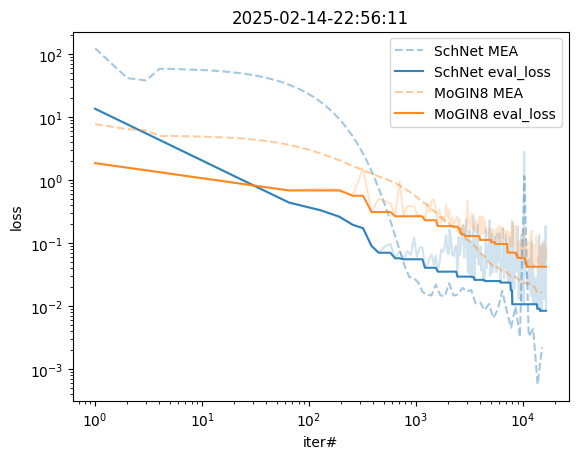

In [64]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
for name,c in zip(models,['tab:'+cn for cn in ('blue','orange','green','red','purple','brown','pink','gray','olive','cyan')]):
    plt.plot(pd.Series(models[name]['train_loss_record']),label=name+' MEA',linestyle='--',alpha=0.4,c=c)
    plt.plot(pd.Series(models[name]['test_loss_record']),alpha=0.2,c=c)
    plt.plot(pd.Series(models[name]['test_loss_record']).cummin(),label=name+' eval_loss',alpha=0.9,c=c)
    
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

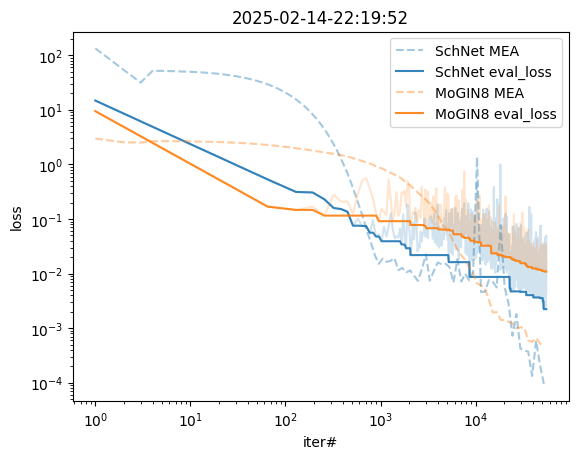

In [26]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
for name,c in zip(models,['tab:'+cn for cn in ('blue','orange','green','red','purple','brown','pink','gray','olive','cyan')]):
    plt.plot(pd.Series(models[name]['train_loss_record']),label=name+' MEA',linestyle='--',alpha=0.4,c=c)
    plt.plot(pd.Series(models[name]['test_loss_record']),alpha=0.2,c=c)
    plt.plot(pd.Series(models[name]['test_loss_record']).cummin(),label=name+' eval_loss',alpha=0.9,c=c)
    
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

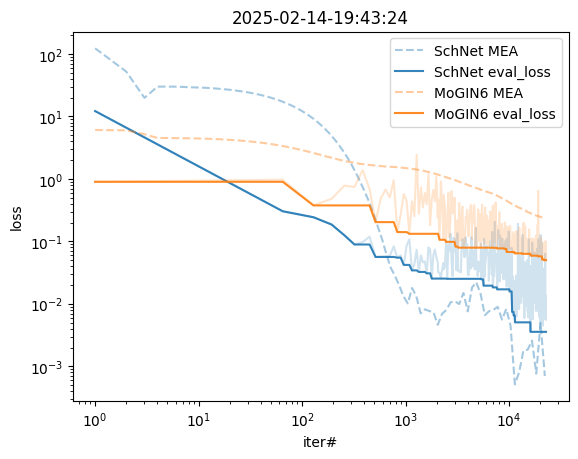

In [122]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
for name,c in zip(models,['tab:'+cn for cn in ('blue','orange','green','red','purple','brown','pink','gray','olive','cyan')]):
    plt.plot(pd.Series(models[name]['train_loss_record']),label=name+' MEA',linestyle='--',alpha=0.4,c=c)
    plt.plot(pd.Series(models[name]['test_loss_record']),alpha=0.2,c=c)
    plt.plot(pd.Series(models[name]['test_loss_record']).cummin(),label=name+' eval_loss',alpha=0.9,c=c)
    
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

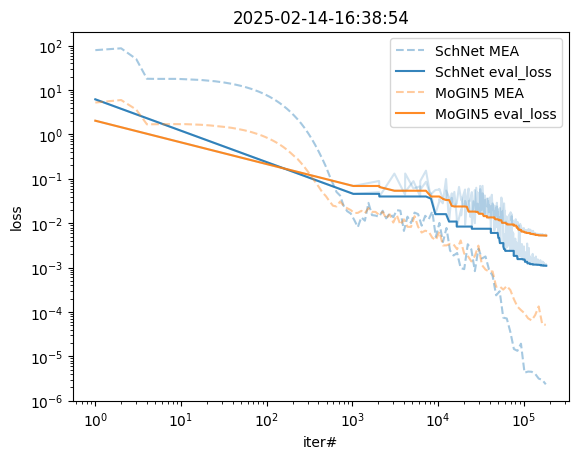

In [30]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
for name,c in zip(models,['tab:'+cn for cn in ('blue','orange','green','red','purple','brown','pink','gray','olive','cyan')]):
    plt.plot(pd.Series(models[name]['train_loss_record']),label=name+' MEA',linestyle='--',alpha=0.4,c=c)
    plt.plot(pd.Series(models[name]['test_loss_record']),alpha=0.2,c=c)
    plt.plot(pd.Series(models[name]['test_loss_record']).cummin(),label=name+' eval_loss',alpha=0.9,c=c)
    
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

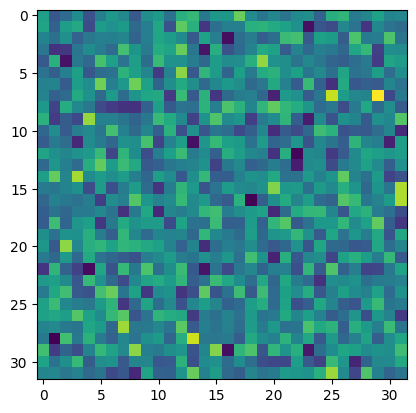

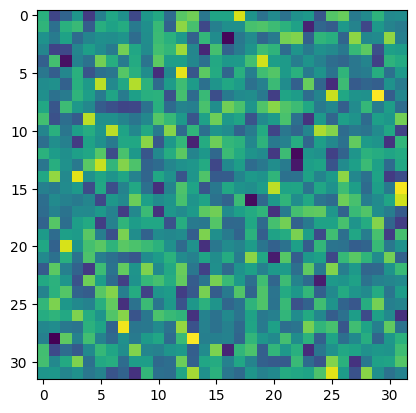

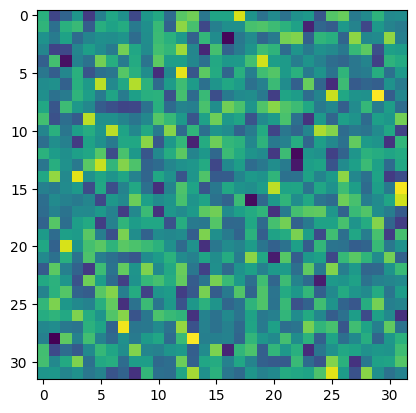

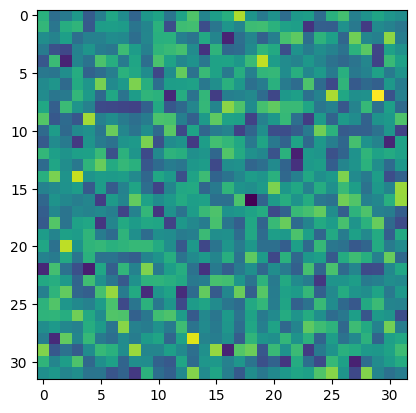

In [74]:
n_samples=32
n_features=32
tmp=torch.randn(n_samples,n_features)*2+3
imshow(tmp)
plt.show()
norm=nn.InstanceNorm1d(n_samples)
tmp2=norm(tmp)
_=imshow(tmp2)
plt.show()
norm=nn.LayerNorm(n_features)
tmp2=norm(tmp)
_=imshow(tmp2)
plt.show()
norm=nn.BatchNorm1d(n_features)
tmp2=norm(tmp)
_=imshow(tmp2)

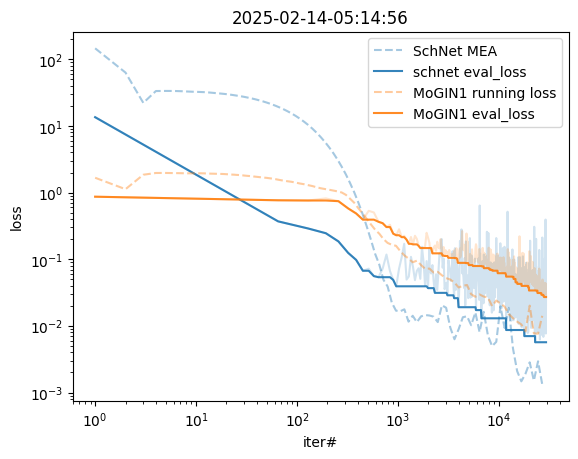

In [42]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
plt.plot(pd.Series(models['SchNet']['train_loss_record']),label='SchNet MEA',linestyle='--',alpha=0.4,c='tab:blue')
plt.plot(pd.Series(models['SchNet']['test_loss_record']),alpha=0.2,c='tab:blue')
plt.plot(pd.Series(models['SchNet']['test_loss_record']).cummin(),label='schnet eval_loss',alpha=0.9,c='tab:blue')

plt.plot(pd.Series(models['MoGIN2']['train_loss_record']),label='MoGIN1 running loss',linestyle='--',alpha=0.4,c='tab:orange')
plt.plot(pd.Series(models['MoGIN2']['test_loss_record']),alpha=0.2,c='tab:orange')
plt.plot(pd.Series(models['MoGIN2']['test_loss_record']).cummin(),label='MoGIN1 eval_loss',alpha=0.9,c='tab:orange')
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

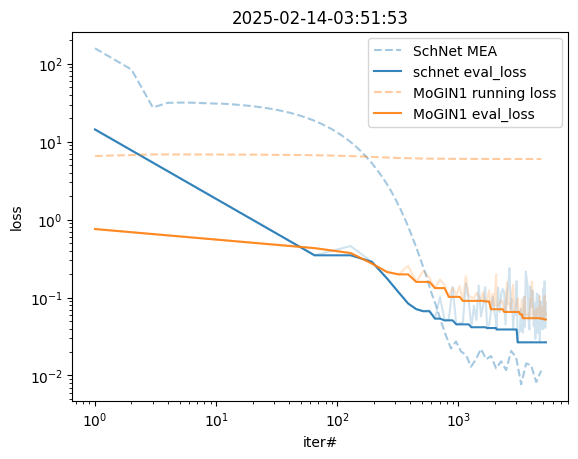

In [30]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
plt.plot(pd.Series(models['schnet']['train_loss_record']),label='SchNet MEA',linestyle='--',alpha=0.4,c='tab:blue')
plt.plot(pd.Series(models['schnet']['test_loss_record']),alpha=0.2,c='tab:blue')
plt.plot(pd.Series(models['schnet']['test_loss_record']).cummin(),label='schnet eval_loss',alpha=0.9,c='tab:blue')

plt.plot(pd.Series(models['MoGIN']['train_loss_record']),label='MoGIN1 running loss',linestyle='--',alpha=0.4,c='tab:orange')
plt.plot(pd.Series(models['MoGIN']['test_loss_record']),alpha=0.2,c='tab:orange')
plt.plot(pd.Series(models['MoGIN']['test_loss_record']).cummin(),label='MoGIN1 eval_loss',alpha=0.9,c='tab:orange')
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

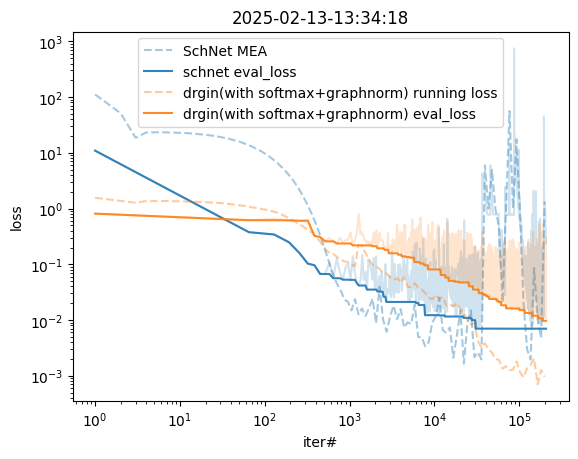

In [24]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
plt.plot(pd.Series(models['schnet']['train_loss_record']),label='SchNet MEA',linestyle='--',alpha=0.4,c='tab:blue')
plt.plot(pd.Series(models['schnet']['test_loss_record']),alpha=0.2,c='tab:blue')
plt.plot(pd.Series(models['schnet']['test_loss_record']).cummin(),label='schnet eval_loss',alpha=0.9,c='tab:blue')

plt.plot(pd.Series(models['DRGIN']['train_loss_record']),label='drgin(with softmax+graphnorm) running loss',linestyle='--',alpha=0.4,c='tab:orange')
plt.plot(pd.Series(models['DRGIN']['test_loss_record']),alpha=0.2,c='tab:orange')
plt.plot(pd.Series(models['DRGIN']['test_loss_record']).cummin(),label='drgin(with softmax+graphnorm) eval_loss',alpha=0.9,c='tab:orange')
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

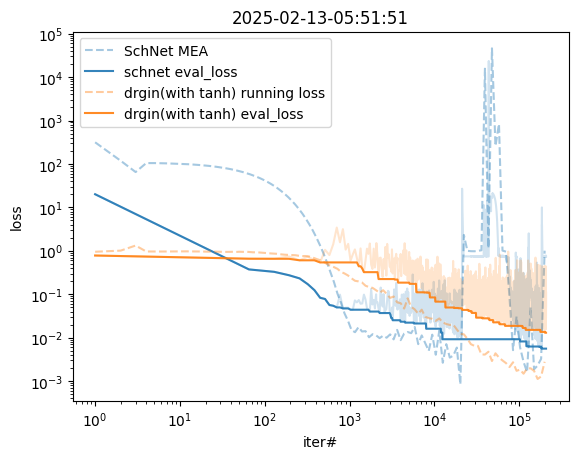

In [23]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
plt.plot(pd.Series(models['schnet']['train_loss_record']),label='SchNet MEA',linestyle='--',alpha=0.4,c='tab:blue')
plt.plot(pd.Series(models['schnet']['test_loss_record']),alpha=0.2,c='tab:blue')
plt.plot(pd.Series(models['schnet']['test_loss_record']).cummin(),label='schnet eval_loss',alpha=0.9,c='tab:blue')

plt.plot(pd.Series(models['DRGIN']['train_loss_record']),label='drgin(with tanh) running loss',linestyle='--',alpha=0.4,c='tab:orange')
plt.plot(pd.Series(models['DRGIN']['test_loss_record']),alpha=0.2,c='tab:orange')
plt.plot(pd.Series(models['DRGIN']['test_loss_record']).cummin(),label='drgin(with tanh) eval_loss',alpha=0.9,c='tab:orange')
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

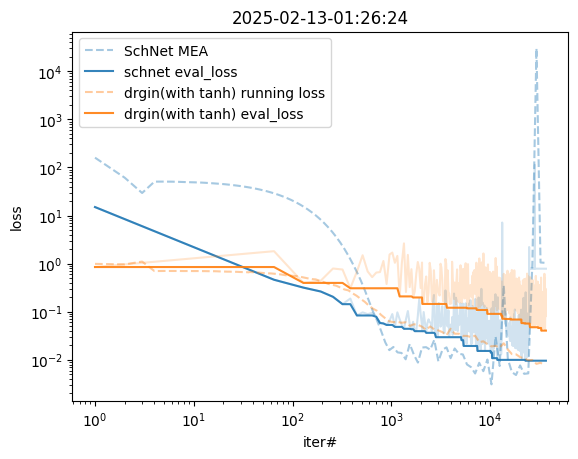

In [24]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
plt.plot(pd.Series(models['schnet']['train_loss_record']),label='SchNet MEA',linestyle='--',alpha=0.4,c='tab:blue')
plt.plot(pd.Series(models['schnet']['test_loss_record']),alpha=0.2,c='tab:blue')
plt.plot(pd.Series(models['schnet']['test_loss_record']).cummin(),label='schnet eval_loss',alpha=0.9,c='tab:blue')

plt.plot(pd.Series(models['DRGIN3']['train_loss_record']),label='drgin(with tanh) running loss',linestyle='--',alpha=0.4,c='tab:orange')
plt.plot(pd.Series(models['DRGIN3']['test_loss_record']),alpha=0.2,c='tab:orange')
plt.plot(pd.Series(models['DRGIN3']['test_loss_record']).cummin(),label='drgin(with tanh) eval_loss',alpha=0.9,c='tab:orange')
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

In [27]:
print(models['schnet']['best_eval_loss'])
print(models['DRGIN']['best_eval_loss'])

0.005599798168987036
0.013037568889558315


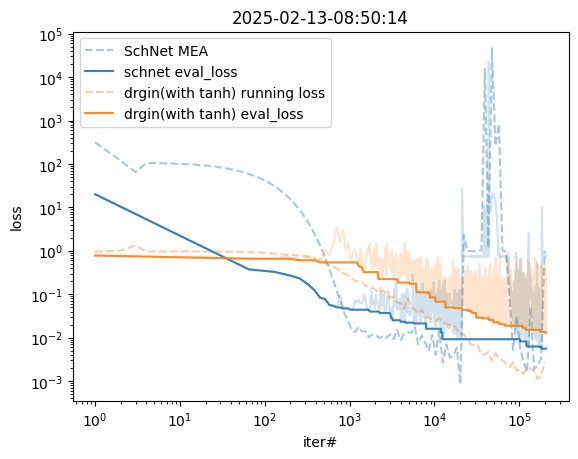

In [26]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
plt.plot(pd.Series(models['schnet']['train_loss_record']),label='SchNet MEA',linestyle='--',alpha=0.4,c='tab:blue')
plt.plot(pd.Series(models['schnet']['test_loss_record']),alpha=0.2,c='tab:blue')
plt.plot(pd.Series(models['schnet']['test_loss_record']).cummin(),label='schnet eval_loss',alpha=0.9,c='tab:blue')

plt.plot(pd.Series(models['DRGIN']['train_loss_record']),label='drgin(with tanh) running loss',linestyle='--',alpha=0.4,c='tab:orange')
plt.plot(pd.Series(models['DRGIN']['test_loss_record']),alpha=0.2,c='tab:orange')
plt.plot(pd.Series(models['DRGIN']['test_loss_record']).cummin(),label='drgin(with tanh) eval_loss',alpha=0.9,c='tab:orange')
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

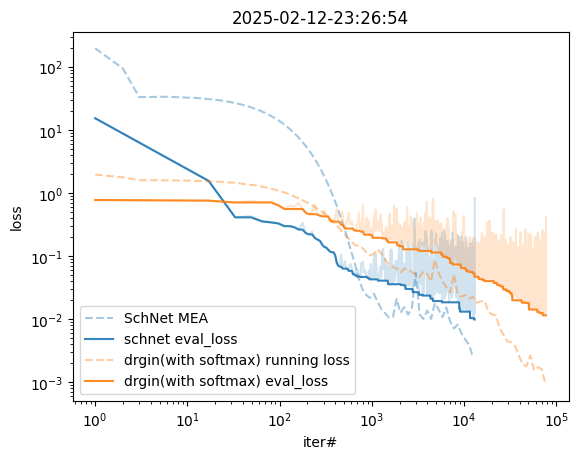

In [107]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
plt.plot(pd.Series(models['schnet']['train_loss_record']),label='SchNet MEA',linestyle='--',alpha=0.4,c='tab:blue')
plt.plot(pd.Series(models['schnet']['test_loss_record']),alpha=0.2,c='tab:blue')
plt.plot(pd.Series(models['schnet']['test_loss_record']).cummin(),label='schnet eval_loss',alpha=0.9,c='tab:blue')

plt.plot(pd.Series(models['DRGIN']['train_loss_record']),label='drgin(with softmax) running loss',linestyle='--',alpha=0.4,c='tab:orange')
plt.plot(pd.Series(models['DRGIN']['test_loss_record']),alpha=0.2,c='tab:orange')
plt.plot(pd.Series(models['DRGIN']['test_loss_record']).cummin(),label='drgin(with softmax) eval_loss',alpha=0.9,c='tab:orange')
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

Text(0.5, 0, 'iter#')

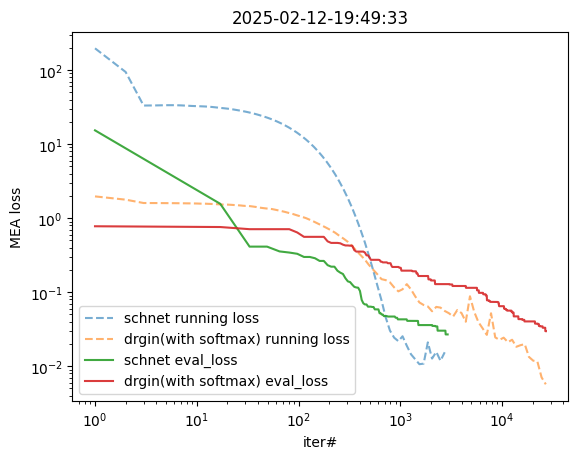

In [52]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
plt.plot(pd.Series(models['schnet']['train_loss_record']),label='schnet running loss',linestyle='--',alpha=0.6)
plt.plot(pd.Series(models['DRGIN']['train_loss_record']),label='drgin(with softmax) running loss',linestyle='--',alpha=0.6)
plt.plot(pd.Series(models['schnet']['test_loss_record']).cummin(),label='schnet eval_loss',alpha=0.9)
plt.plot(pd.Series(models['DRGIN']['test_loss_record']).cummin(),label='drgin(with softmax) eval_loss',alpha=0.9)
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("MEA loss")
plt.xlabel("iter#")
#plt.gcf().savefig(f"loss_record-{tsfs}.svg")

In [44]:
pd.Series(models['schnet']['test_loss_record']).ewm(0.9).mean()

1       15.339844
17       5.989957
33       2.705190
49       1.444638
65       0.857235
          ...    
2851     0.101765
2867     0.096062
2883     0.069010
2899     0.058110
2915     0.214491
Length: 184, dtype: float64

In [46]:
pd.Series(models['schnet']['test_loss_record'])

1       15.339844
17       1.561063
33       0.412223
49       0.430719
65       0.355188
          ...    
2851     0.153782
2867     0.090929
2883     0.044664
2899     0.048299
2915     0.355234
Length: 184, dtype: float64

Text(0.5, 0, 'iter#')

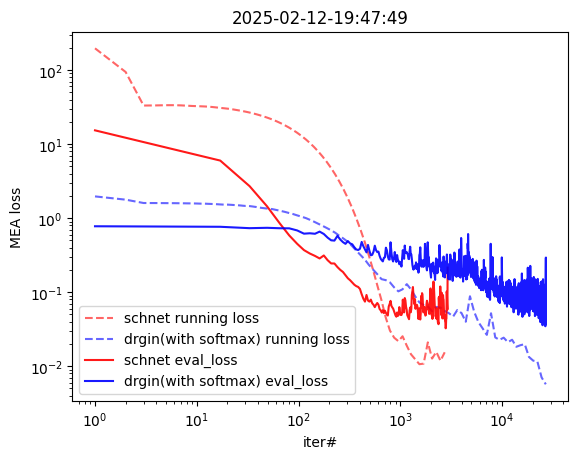

In [51]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
plt.plot(pd.Series(models['schnet']['train_loss_record']),label='schnet running loss',linestyle='--',alpha=0.6,c='r')
plt.plot(pd.Series(models['DRGIN']['train_loss_record']),label='drgin(with softmax) running loss',linestyle='--',alpha=0.6,c='b')
plt.plot(pd.Series(models['schnet']['test_loss_record']).ewm(0.9).mean(),label='schnet eval_loss',alpha=0.9,c='r')
plt.plot(pd.Series(models['DRGIN']['test_loss_record']).ewm(0.9).mean(),label='drgin(with softmax) eval_loss',alpha=0.9,c='b')
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("MEA loss")
plt.xlabel("iter#")
#plt.gcf().savefig(f"loss_record-{tsfs}.svg")

Text(0.5, 0, 'iter#')

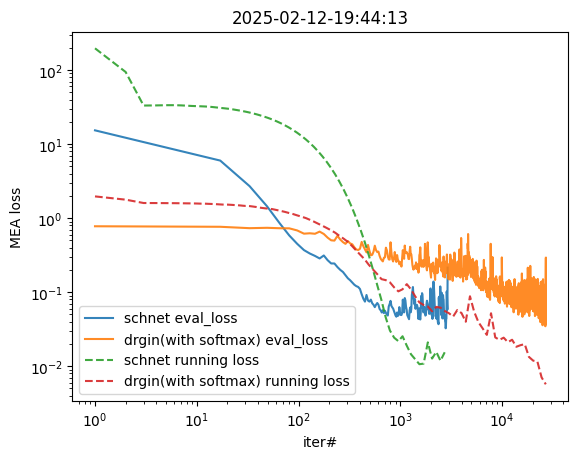

In [47]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
plt.plot(pd.Series(models['schnet']['test_loss_record']).ewm(0.9).mean(),label='schnet eval_loss',alpha=0.9)
plt.plot(pd.Series(models['DRGIN']['test_loss_record']).ewm(0.9).mean(),label='drgin(with softmax) eval_loss',alpha=0.9)
plt.plot(pd.Series(models['schnet']['train_loss_record']),label='schnet running loss',linestyle='--',alpha=0.9)
plt.plot(pd.Series(models['DRGIN']['train_loss_record']),label='drgin(with softmax) running loss',linestyle='--',alpha=0.9)
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("MEA loss")
plt.xlabel("iter#")
#plt.gcf().savefig(f"loss_record-{tsfs}.svg")

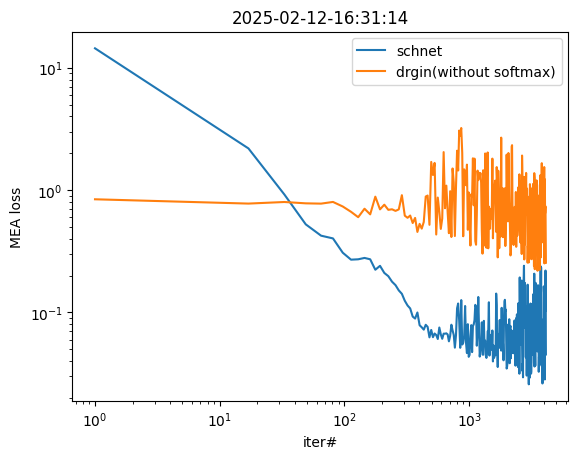

In [24]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
plt.plot(pd.Series(models['schnet']['test_loss_record']),label='schnet')
plt.plot(pd.Series(models['DRGIN']['test_loss_record']),label='drgin(without softmax)')
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("MEA loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

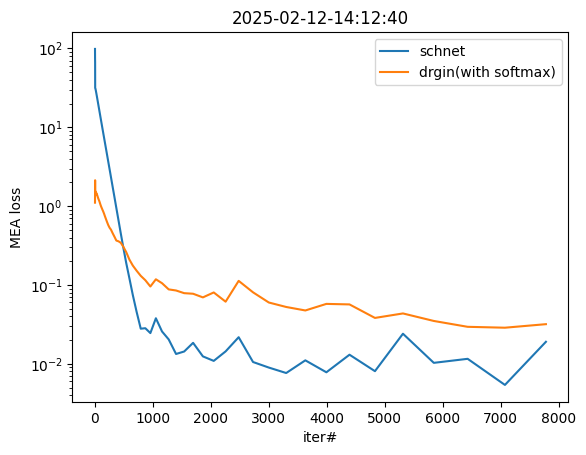

In [21]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
plt.plot(pd.Series(models['schnet']['test_loss_record']),label='schnet')
plt.plot(pd.Series(models['DRGIN']['test_loss_record']),label='drgin(without softmax)')
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
#plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("MEA loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

Text(0.5, 0, 'iter#')

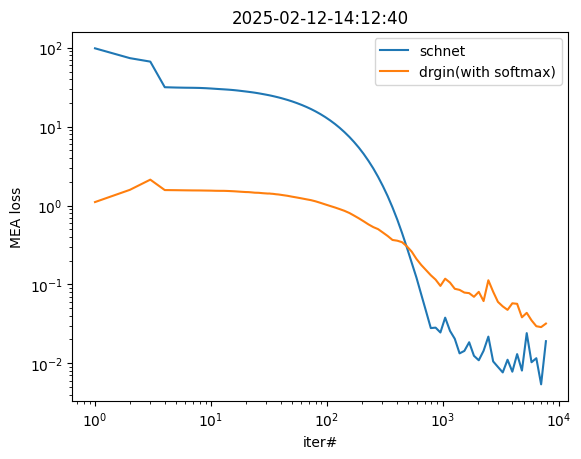

In [23]:
plt.plot(pd.Series(record_loss_schnet),label='schnet')
plt.plot(pd.Series(record_loss_schnet2),label='drgin(with softmax)')
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("MEA loss")
plt.xlabel("iter#")

In [ ]:
pd.Series(record_loss_schnet)

In [25]:
41419/2081

19.90341182123979

In [26]:
torch.ones_like

<function torch._VariableFunctionsClass.ones_like>

Text(0.5, 0, 'iter#')

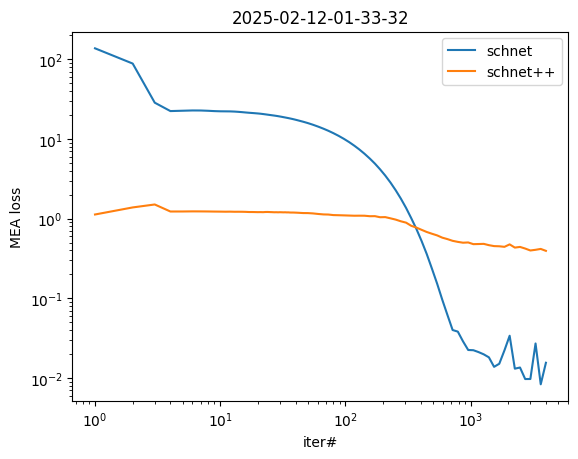

In [68]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
plt.plot(pd.Series(record_loss_schnet),label='schnet')
plt.plot(pd.Series(record_loss_schnet2),label='schnet++')
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("MEA loss")
plt.xlabel("iter#")
#plt.gcf().savefig(f"loss_record-{ts}.svg")

Text(0.5, 0, 'iter#')

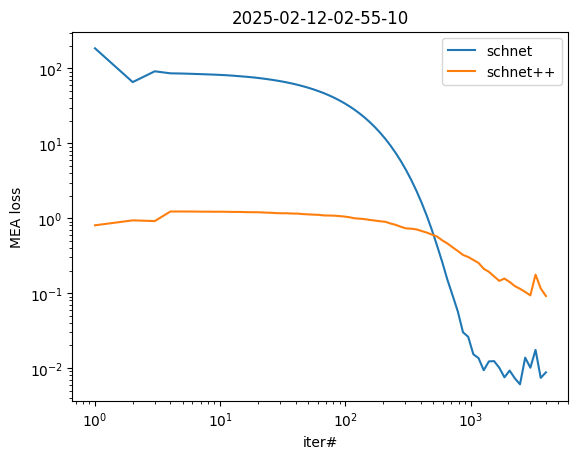

In [22]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
plt.plot(pd.Series(record_loss_schnet),label='schnet')
plt.plot(pd.Series(record_loss_schnet2),label='schnet++')
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("MEA loss")
plt.xlabel("iter#")
#plt.gcf().savefig(f"loss_record-{ts}.svg")

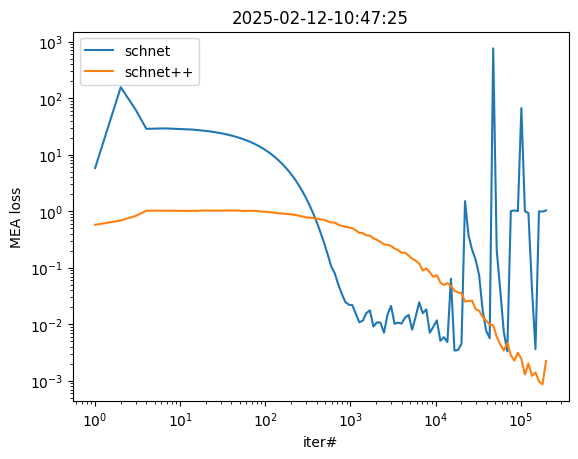

In [22]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
plt.plot(pd.Series(record_loss_schnet),label='schnet')
plt.plot(pd.Series(record_loss_schnet2),label='schnet++')
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("MEA loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

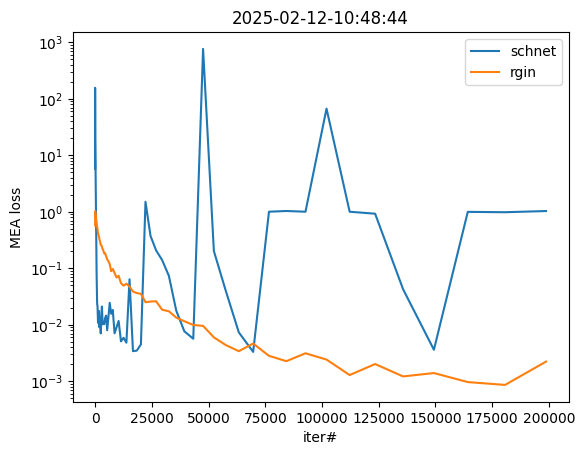

In [24]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
plt.plot(pd.Series(record_loss_schnet),label='schnet')
plt.plot(pd.Series(record_loss_schnet2),label='rgin')
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
#plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("MEA loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-{tsfs}.svg")

Text(0.5, 0, 'iter#')

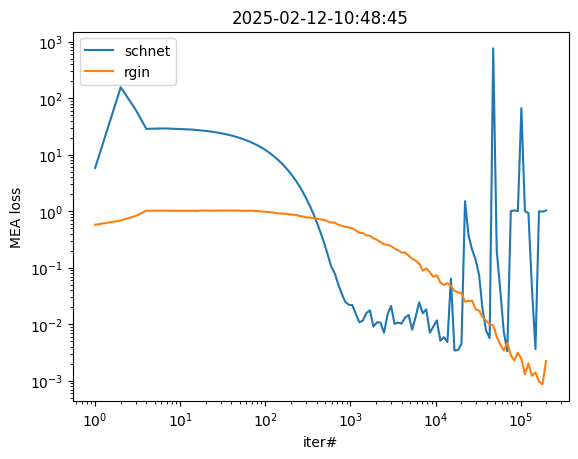

In [25]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
plt.plot(pd.Series(record_loss_schnet),label='schnet')
plt.plot(pd.Series(record_loss_schnet2),label='rgin')
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("MEA loss")
plt.xlabel("iter#")
#plt.gcf().savefig(f"loss_record-{tsfs}.svg")

```python
import numpy as np
BATCH_SIZE=64
N_EPOCHS=100
N_mols=len(qm9)
long_bar=tqdm(range(N_EPOCHS*N_mols//BATCH_SIZE))
e_bar=tqdm(range(N_mols//BATCH_SIZE))
running_loss_rgin=0
running_loss_rgcn=0
running_loss_schnet=0
RESET_RECORD=True
UPDATE_RECORD=True
TRAINING=True
results_rgin=[]
results_rgcn=[]
results_schnet=[]
truths=[]
if RESET_RECORD:
    if not TRAINING:
        raise Exception("invalid combination of options")
    record_loss_rgin=[]
    record_loss_rgcn=[]
    record_loss_schnet=[]
    total_iters=0
if TRAINING:
    rgin=rgin.train()
    rgcn=rgcn.train()
    schnet=schnet.train()
else:
    rgin=rgin.eval()
    rgcn=rgcn.eval()
    schnet=schnet.eval()


for epoch in range(N_EPOCHS):
    e_bar.refresh()
    e_bar.reset(N_mols//BATCH_SIZE)
    bl=DataLoader(qm9, batch_size=BATCH_SIZE, shuffle=True)
    for i, batch in zip(range(N_mols//BATCH_SIZE), bl):
        long_bar.update(1)
        e_bar.update(1)
        if TRAINING:
            total_iters+=1
        try:
            batch=(batch.to(cuda))
            y=(batch[YCOL]-__mean)/__std
            
            ### train rgin
            if TRAINING:
                out = rgin(batch)#(X, A, T, dest, inbound, ang_deltas, batch=b)
                loss = ((out-y)**2).mean()
                rgin.zero_grad(set_to_none=True)
                if UPDATE_RECORD:
                    if total_iters<5:
                        running_loss_rgin = running_loss_rgin*.3+loss.item()*.7
                    else:
                        running_loss_rgin = running_loss_rgin*(1-1/100)+loss.item()/100
                    if total_iters+.1001>1.1**len(record_loss_rgin):
                        record_loss_rgin.append(running_loss_rgin)
                loss.backward()
                rgin_optimizer.step()
            else:
                with torch.no_grad():
                    results_rgin+=rgin(batch).view(-1).tolist()
                    
            ### train rgcn
            if TRAINING:
                out = rgcn(batch)#X, A, E, batch=b)
                loss = ((out-y)**2).mean()
                rgcn.zero_grad(set_to_none=True)
                if UPDATE_RECORD:
                    if total_iters<5:
                        running_loss_rgcn = running_loss_rgcn*.3+loss.item()*.7
                    else:
                        running_loss_rgcn = running_loss_rgcn*(1-1/100)+loss.item()/100
                    if total_iters+.2>1.1**len(record_loss_rgcn):
                        record_loss_rgcn.append(running_loss_rgcn)
                loss.backward()
                rgcn_optimizer.step()
            else:
                with torch.no_grad():
                    results_rgcn+=rgcn(batch).view(-1).tolist()
                    
            ### train schnet
            if TRAINING:
                out = schnet(batch)#X, A, E, batch=b)
                loss = ((out-y)**2).mean()
                schnet.zero_grad(set_to_none=True)
                if UPDATE_RECORD:
                    if total_iters<5:
                        running_loss_schnet = running_loss_schnet*.3+loss.item()*.7
                    else:
                        running_loss_schnet = running_loss_schnet*(1-1/100)+loss.item()/100
                    if total_iters+.2>1.1**len(record_loss_schnet):
                        record_loss_schnet.append(running_loss_schnet)
                loss.backward()
                schnet_optimizer.step()
            else:
                with torch.no_grad():
                    results_schnet+=schnet(batch).view(-1).tolist()

            ###logging
            if TRAINING:
                e_bar.set_description(f"\
rgin:{int(100*running_loss_rgin)/100}. \
rgcn:{int(100*running_loss_rgcn)/100}. \
schnet:{int(100*running_loss_schnet)/100}. \
")
            else:
                truths+=y.view(-1).tolist()
        except Exception as e:
            print("error on",total_iters,e)
            raise e
    if not TRAINING:
        break
```

In [ ]:
schnet(batch).shape,rgcn(batch).shape,rgin(batch).shape

In [ ]:
batch

In [ ]:
loss

In [ ]:
record_loss_rgcn[-1],record_loss_rgin[-1]

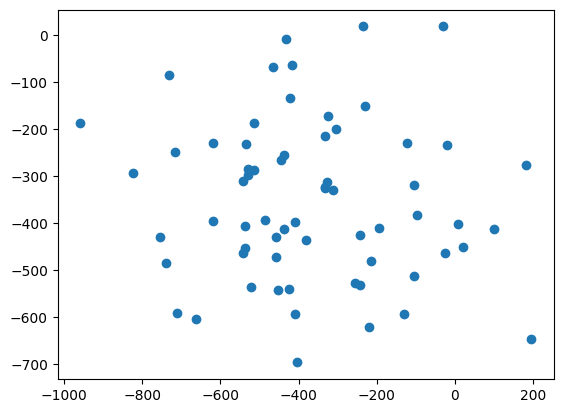

In [165]:
__y=(out*width+offset).detach().cpu().numpy()
__x=(y*width+offset).detach().cpu().numpy()
plt.scatter(__x,__y)

In [166]:
abs(__y-__x).mean()

244.78299

In [47]:
out

tensor([ 0.8180, -1.3554, -1.4370, -0.7086,  0.9014,  0.9481, -0.4938,  0.5365,
         0.4769, -0.3613, -0.0736,  1.7695,  0.2907, -0.9655,  0.8414, -0.8344,
        -0.0066, -1.9910, -1.0272,  0.8579, -1.0235,  0.4143, -0.0443, -0.9343,
         1.3588, -0.7798, -0.9609, -0.9640,  0.6799, -0.8485,  0.7278, -0.8806,
         0.2566,  0.3534, -0.8474, -0.0990, -0.0252,  0.0572, -0.0542,  0.1146,
         0.1543,  0.2626, -0.8576,  0.7496,  0.2906, -1.0026, -0.9187, -0.3129,
         1.2712, -0.0573, -0.6160,  0.0357,  0.4616, -0.0811, -0.6836, -0.0688,
        -0.1598, -0.4604,  0.3033, -0.5491,  0.0073, -0.0317, -0.0783, -0.0235],
       device='cuda:0', grad_fn=<MeanBackward1>)

In [197]:
results_rgin_series=pd.Series(results_rgin)
results_rgcn_series=pd.Series(results_rgcn)
truths_series=pd.Series(truths)

In [ ]:
len(qm9)

In [29]:
import uuid
import inspect
import datetime


'250204'

In [152]:
from models.rgin import RGIN

In [46]:
save_model(f"SchNet10EpochU0QM9", schnet,
           loss_metric='MSE',loss_record=record_loss_schnet,
           optimizer=schnet_optimizer, total_training_iters=total_iters,
           last_target_name='normalized_u0',last_dataset_name='qm9',
          )
save_model(f"DRGIN10EpochU0QM9", schnet2,
           loss_metric='MSE',loss_record=record_loss_schnet2,
           optimizer=schnet2_optimizer, total_training_iters=total_iters,
           last_target_name='normalized_u0',last_dataset_name='qm9',
          )

In [32]:
schnet_loaded=load_model(f"SchNet10EpochU0QM9-250212", SchNet).cuda()
drgin_loaded=load_model(f"DRGIN10EpochU0QM9-250212", DRGIN).cuda()

In [42]:
with torch.no_grad():
    assert((drgin_loaded(batch)-schnet2(batch)).abs()<1e-6).all()

In [36]:
for p1,p2 in zip(schnet2.parameters(),drgin_loaded.parameters()):
    assert (p1==p2).all()

In [43]:
import numpy as np
BATCH_SIZE=64
N_EPOCHS=100
N_mols=len(qm9)
long_bar=tqdm(range(N_EPOCHS*N_mols//BATCH_SIZE))
e_bar=tqdm(range(N_mols//BATCH_SIZE))
results_schnet=[]
results_schnet2=[]
truths=[]
schnet_loaded=schnet_loaded.eval()
drgin_loaded=drgin_loaded.eval()
#torch.autograd.set_detect_anomaly(True)

for i, batch in zip(range(N_mols//BATCH_SIZE), bl):
    long_bar.update(1)
    e_bar.update(1)
    if TRAINING:
        total_iters+=1
    try:
        batch=(batch.to(cuda))
        y=(batch[YCOL]-__mean)/__std
        
        with torch.no_grad():
            results_schnet+=schnet_loaded(batch).view(-1).tolist()
                
        with torch.no_grad():
            results_schnet2+=drgin_loaded(batch).view(-1).tolist()

        truths+=y.view(-1).tolist()
    except Exception as e:
        print("error on",total_iters,e)
        raise e

  0%|          | 0/208198 [00:00<?, ?it/s]

  0%|          | 0/2081 [00:00<?, ?it/s]

In [51]:
results_schnet_series=pd.Series(results_schnet)
results_drgin_series=pd.Series(results_schnet2)
truths_series=pd.Series(truths)

In [38]:
schnet2

DRGIN(
  (rgins): ModuleList(
    (0-5): 6 x RGINConv()
  )
  (norms): ModuleList(
    (0-4): 5 x GraphNorm(50)
    (5): GraphNorm(1)
  )
  (atom_type_emb): Embedding(200, 120)
  (interaction_graph): RadiusInteractionGraph()
  (dist_norm): BatchNorm(1)
)

In [158]:
from models.rgin import RGIN

In [159]:
RGIN.from_config(rgin.get_config()).load_state_dict(rgin.state_dict())

<All keys matched successfully>

In [ ]:
from_qm9_pretrained

In [328]:
truths_series.shape,results_xgcn_series.shape,results_rgcn_series.shape

((133184,), (133184,), (133184,))

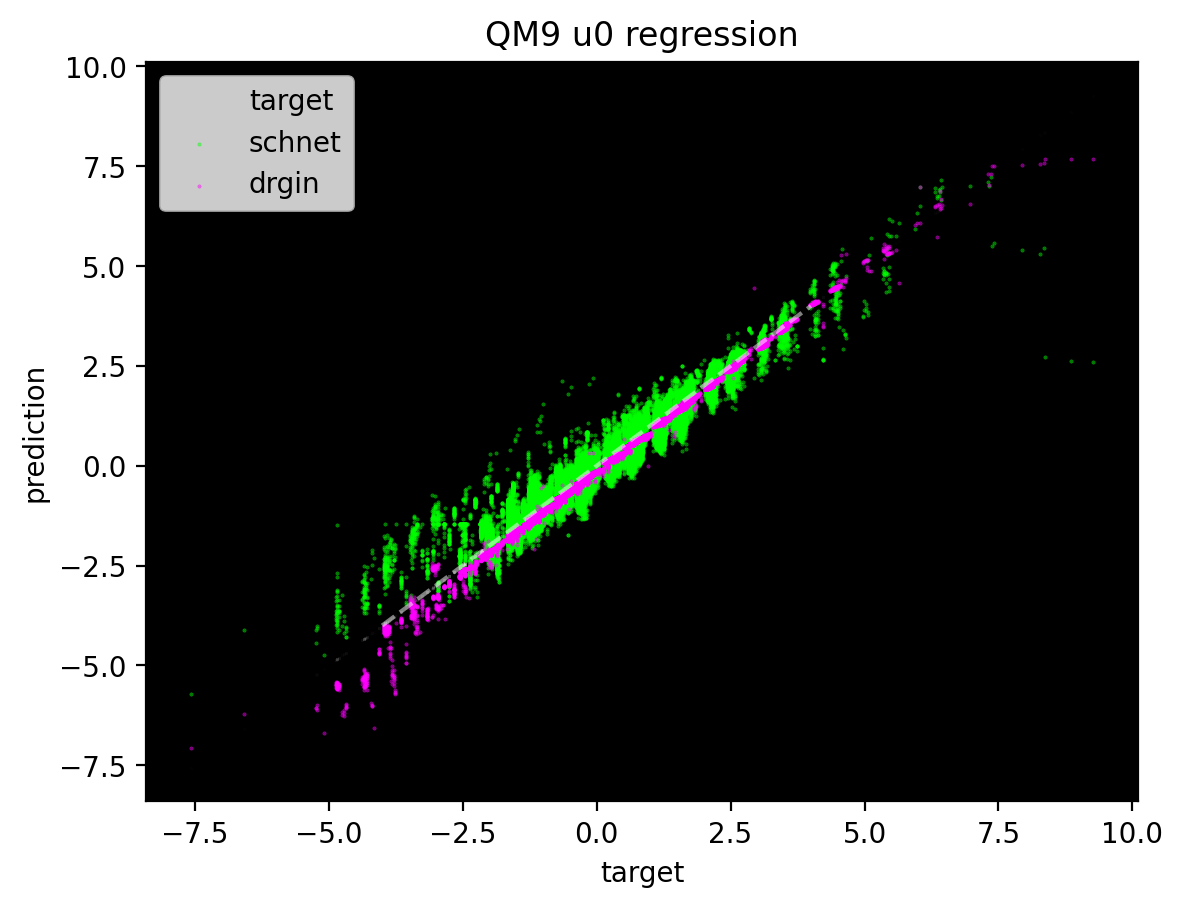

In [52]:
plt.plot((-4,4),(-4,4),linestyle='--',c='#fff',alpha=0.5)
plt.scatter(truths_series,truths_series,label='target',c='#fff',s=0.2,alpha=0.01)
plt.scatter(truths_series,results_schnet_series,label='schnet',c='#0f0',s=0.2,alpha=0.52)
plt.scatter(truths_series,results_drgin_series,label='drgin',c='#f0f',s=0.2,alpha=0.52)
plt.xlabel("target")
plt.ylabel("prediction")
plt.legend()
plt.title("QM9 u0 regression")
plt.gca().set_facecolor('black')
plt.gcf().set_dpi(200)

In [207]:
mae_rgin=((truths_series-results_rgin_series)).abs().mean()
mse_rgin=((truths_series-results_rgin_series)**2).mean()
mae_rgcn=((truths_series-results_rgcn_series)).abs().mean()
mse_rgcn=((truths_series-results_rgcn_series)**2).mean()
print(f"MAE RGIN: {mae_rgin:.3f}")
print(f"MAE RGCN: {mae_rgcn:.3f}")
print(f"MSE RGIN: {mse_rgin:.3f}")
print(f"MSE RGCN: {mse_rgcn:.3f}")


MAE RGIN: 0.317
MAE RGCN: 0.288
MSE RGIN: 0.204
MSE RGCN: 0.247


In [143]:
1.1**(len(record_loss_schnet)-.5)

25604.77532386932

In [199]:
25229

0.2875789506995091

0.24677050828626682

Text(0.5, 1.0, "QM9 u0 regression (delta's pdf)")

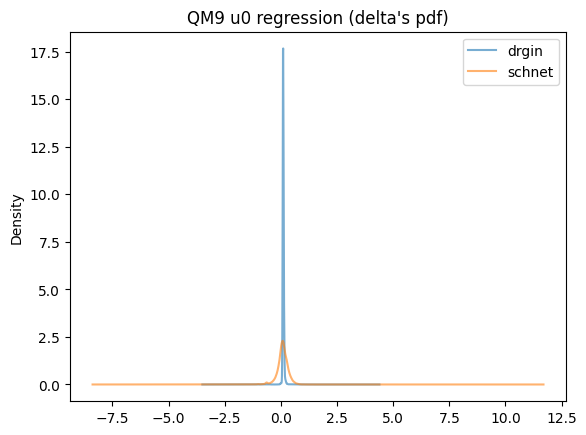

In [53]:
(truths_series-results_drgin_series).plot.kde(label='drgin', alpha=0.6)
(truths_series-results_schnet_series).plot.kde(label='schnet', alpha=0.6)
plt.legend()
plt.title("QM9 u0 regression (delta's pdf)")

```python
class MessagePassing(torch.nn.Module):

    special_args: Set[str] = {
        'edge_index', 'adj_t', 'edge_index_i', 'edge_index_j', 'size',
        'size_i', 'size_j', 'ptr', 'index', 'dim_size'
    }

    # Supports `message_and_aggregate` via `EdgeIndex`.
    # TODO Remove once migration is finished.
    SUPPORTS_FUSED_EDGE_INDEX: Final[bool] = False

    def __init__(
        self,
        aggr: Optional[Union[str, List[str], Aggregation]] = 'sum',
        *,
        aggr_kwargs: Optional[Dict[str, Any]] = None,
        flow: str = "source_to_target",
        node_dim: int = -2,
        decomposed_layers: int = 1,
    ) -> None:
        super().__init__()

        if flow not in ['source_to_target', 'target_to_source']:
            raise ValueError(f"Expected 'flow' to be either 'source_to_target'"
                             f" or 'target_to_source' (got '{flow}')")

        # Cast `aggr` into a string representation for backward compatibility:
        self.aggr: Optional[Union[str, List[str]]]
        if aggr is None:
            self.aggr = None
        elif isinstance(aggr, (str, Aggregation)):
            self.aggr = str(aggr)
        elif isinstance(aggr, (tuple, list)):
            self.aggr = [str(x) for x in aggr]

        self.aggr_module = aggr_resolver(aggr, **(aggr_kwargs or {}))
        self.flow = flow
        self.node_dim = node_dim

     
    # Message Passing #########################################################

[docs]
    def forward(self, *args: Any, **kwargs: Any) -> Any:
        r"""Runs the forward pass of the module."""


[docs]
    def propagate(
        self,
        edge_index: Adj,
        size: Size = None,
        **kwargs: Any,
    ) -> Tensor:
        decomposed_layers = 1 if self.explain else self.decomposed_layers

        for hook in self._propagate_forward_pre_hooks.values():
            res = hook(self, (edge_index, size, kwargs))
            if res is not None:
                edge_index, size, kwargs = res

        mutable_size = self._check_input(edge_index, size)

        # Run "fused" message and aggregation (if applicable).
        fuse = False
        if self.fuse and not self.explain:
            if is_sparse(edge_index):
                fuse = True
            elif (not torch.jit.is_scripting()
                  and isinstance(edge_index, EdgeIndex)):
                if (self.SUPPORTS_FUSED_EDGE_INDEX
                        and edge_index.is_sorted_by_col):
                    fuse = True

        if fuse:
            coll_dict = self._collect(self._fused_user_args, edge_index,
                                      mutable_size, kwargs)

            msg_aggr_kwargs = self.inspector.collect_param_data(
                'message_and_aggregate', coll_dict)
            for hook in self._message_and_aggregate_forward_pre_hooks.values():
                res = hook(self, (edge_index, msg_aggr_kwargs))
                if res is not None:
                    edge_index, msg_aggr_kwargs = res
            out = self.message_and_aggregate(edge_index, **msg_aggr_kwargs)
            for hook in self._message_and_aggregate_forward_hooks.values():
                res = hook(self, (edge_index, msg_aggr_kwargs), out)
                if res is not None:
                    out = res

            update_kwargs = self.inspector.collect_param_data(
                'update', coll_dict)
            out = self.update(out, **update_kwargs)

        else:  # Otherwise, run both functions in separation.
            if decomposed_layers > 1:
                user_args = self._user_args
                decomp_args = {a[:-2] for a in user_args if a[-2:] == '_j'}
                decomp_kwargs = {
                    a: kwargs[a].chunk(decomposed_layers, -1)
                    for a in decomp_args
                }
                decomp_out = []

            for i in range(decomposed_layers):
                if decomposed_layers > 1:
                    for arg in decomp_args:
                        kwargs[arg] = decomp_kwargs[arg][i]

                coll_dict = self._collect(self._user_args, edge_index,
                                          mutable_size, kwargs)

                msg_kwargs = self.inspector.collect_param_data(
                    'message', coll_dict)
                
                out = self.message(**msg_kwargs)
                
                aggr_kwargs = self.inspector.collect_param_data(
                    'aggregate', coll_dict)
                
                out = self.aggregate(out, **aggr_kwargs)
                
                update_kwargs = self.inspector.collect_param_data(
                    'update', coll_dict)
                out = self.update(out, **update_kwargs)


        return out


[docs]
    def message(self, x_j: Tensor) -> Tensor:
        return x_j


[docs]
    def aggregate(
        self,
        inputs: Tensor,
        index: Tensor,
        ptr: Optional[Tensor] = None,
        dim_size: Optional[int] = None,
    ) -> Tensor:
        return self.aggr_module(inputs, index, ptr=ptr, dim_size=dim_size,
                                dim=self.node_dim)


[docs]
    @abstractmethod
    def message_and_aggregate(self, edge_index: Adj) -> Tensor:
        raise NotImplementedError


[docs]
    def update(self, inputs: Tensor) -> Tensor:
        return inputs
```